# importok, adatbehivasok

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  
import os
import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix,f1_score, precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from skopt.space import Real, Integer
from skopt import BayesSearchCV

In [3]:
with open('model_ready_dict.pickle', 'rb') as handle:
    model_ready_dict = pickle.load(handle)

for key, df in model_ready_dict.items():
    name = key.replace(" ", "_").lower()
    globals()[name] = df

In [4]:
def convert_decimal_odds_to_probabilities(dfs_dict, odds_columns):

    for key, df in dfs_dict.items():
        for col in odds_columns:
            df[f'prob_{col}'] = 1 / df[col] 
    return dfs_dict

odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
model_ready_dict = convert_decimal_odds_to_probabilities(model_ready_dict, odds)

In [5]:
for key, df in model_ready_dict.items():
    name = key.replace(" ", "_").lower()
    globals()[name] = df

In [6]:
big5 = pd.read_excel("big5_sorted_by_date.xlsx")
big5.drop(columns='Unnamed: 0', inplace=True)

def convert_odds_big5(df, odds_columns):
    for col in odds_columns:
        df[f'prob_{col}'] = 1 / df[col]
    return df

odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']
big5 = convert_odds_big5(big5, odds)

# FTR

## PL, FTR

In [339]:
def logistic_regression_tuning(df, target_col, drop_cols=[], odds=[]):
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))
    test_n = len(df) - train_n - val_n 
    
    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:] 

    print(f"tanító halmaz dimenziók: {train_set.shape}")
    print(f"validációs halmaz dimenziók: {val_set.shape}")
        
    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]

    X_train_odds = X_train[odds]
    X_val_odds = X_val[odds]
    X_train = X_train.drop(columns=odds)
    X_val = X_val.drop(columns=odds)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    
    X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
    X_val_scaled = pd.concat([X_val_scaled, X_val_odds], axis=1)
    
    param_space = [
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l1'],
         'solver': ['liblinear', 'saga'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l2'],
         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['elasticnet'],
         'solver': ['saga'],  
         'l1_ratio': Real(0, 1),
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    ]


    tscv = TimeSeriesSplit(n_splits=5) 
    
    log_reg = LogisticRegression(random_state=1, max_iter=1000)

    bayes_search = BayesSearchCV(
        estimator=log_reg,
        search_spaces=param_space,
        n_iter=50, 
        cv=tscv, 
        scoring='f1',
        refit='f1',
        n_jobs=-1,  
        random_state=1,
        verbose=0
    )
    
    bayes_search.fit(X_train_scaled, y_train)  
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    
    y_pred = best_model.predict(X_val_scaled)
    val_set = val_set.copy()
    val_set.loc[:, 'Predicted'] = y_pred
    
    y_val_probs = best_model.predict_proba(X_val_scaled)
    val_set['P_0'] = y_val_probs[:, 0] 
    val_set['P_1'] = y_val_probs[:, 1]  
    print(classification_report(y_val, y_pred))
    
    plt.figure(figsize=(5, 3))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("ModelL")
    plt.ylabel("Valós")
    plt.show()
    
    feature_importances = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': np.abs(best_model.coef_).flatten()
    }).sort_values(by='importance', ascending=False)
    
    top_20_features = feature_importances.head(20)['feature'].tolist()
    print(top_20_features)

    plt.figure(figsize=(6, 4))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
    plt.xlabel("Fontosság (koef.)")
    plt.ylabel("Változó")
    plt.grid(axis='x')
    plt.show()
    
    return val_set, best_params, top_20_features

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
Accuracy: 0.6622
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       190
           1       0.66      0.64      0.65       180

    accuracy                           0.66       370
   macro avg       0.66      0.66      0.66       370
weighted avg       0.66      0.66      0.66       370



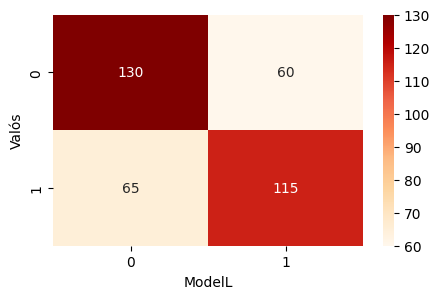

['prob_AwayW_odds_market', 'prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'prob_HomeW_odds_market', 'prob_Draw_odds_market', 'away_expected_points_RA', 'away_np_xg_difference_RA', 'away_np_xg_RA', 'home_np_xg_difference_RA', 'home_expected_points_RA', 'away_xg_RA', 'away_last5_over_2_5_count', 'home_last5_wins_count', 'away_goals_for_RA', 'away_last5_losses_count', 'away_goals_against_RA', 'home_last5_over_2_5_count', 'away_cumulative_goals_diff', 'away_last5_wins_count', 'away_last5_lose_rate']


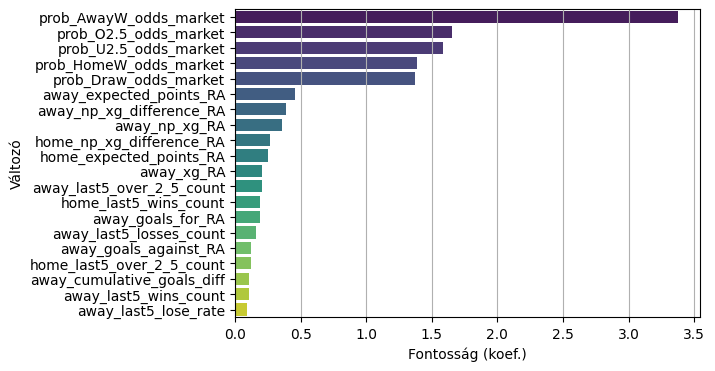

In [340]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


premier_league_tuned_home, premier_league_params_home, premier_league_features_home = logistic_regression_tuning(
    premier_league,
    target_col,
    drop,
    odds
)

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
Accuracy: 0.6351
              precision    recall  f1-score   support

           0       0.81      0.64      0.71       265
           1       0.41      0.63      0.49       105

    accuracy                           0.64       370
   macro avg       0.61      0.63      0.60       370
weighted avg       0.70      0.64      0.65       370



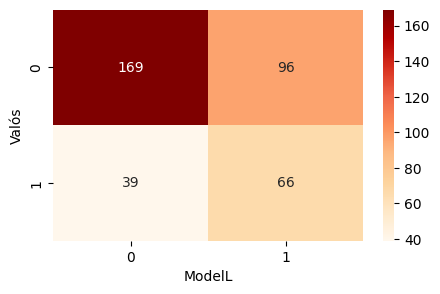

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'prob_Draw_odds_market', 'away_np_xg_difference_RA', 'home_expected_points_RA', 'home_np_xg_difference_RA', 'away_expected_points_RA', 'prob_O2.5_odds_market', 'home_last5_under_2_5_count', 'away_last5_losses_count', 'away_last5_under_2_5_count', 'home_last5_over_2_5_count', 'away_shots_RA', 'prob_U2.5_odds_market', 'away_cumulative_goals_diff', 'home_last5_wins_count', 'home_last5_losses_count', 'away_halftime_goals_RA', 'away_goals_against_RA', 'away_np_xg_RA']


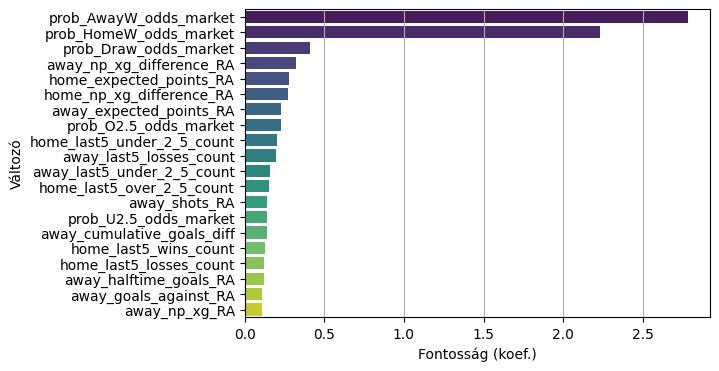

In [341]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

premier_league_tuned_away, premier_league_params_away,premier_league_features_away = logistic_regression_tuning(
    premier_league,
    target_col,
    drop,
    odds
)

### tuned model on train+validation

In [622]:
def logreg_validation(train_data, target_col, drop_cols=[], odds=[], best_params={}):
    """
    Ez a függvény csak a modell tanítását és a scaler létrehozását végzi
    a már előre szétosztott train adatokon.
    """
    train_data = train_data.dropna().reset_index(drop=True)

    X_train = train_data.drop(columns=[target_col] + drop_cols)
    y_train = train_data[target_col]

    X_train_odds = X_train[odds].copy()
    X_train_no_odds = X_train.drop(columns=odds)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_no_odds)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_no_odds.columns)
    
    X_train_final = pd.concat([X_train_scaled.reset_index(drop=True), 
                              X_train_odds.reset_index(drop=True)], axis=1)
    
    logreg = LogisticRegression(
        C=best_params.get('C', 1.0),
        penalty=best_params.get('penalty', 'l2'),
        solver=best_params.get('solver', 'liblinear'),
        class_weight=best_params.get('class_weight', None),
        random_state=best_params.get('random_state', 1),
        max_iter=1000,
        l1_ratio=best_params.get('l1_ratio', 0.5) if best_params.get('penalty') == 'elasticnet' else None  
    )
    
    logreg.fit(X_train_final, y_train)
    
    return logreg, scaler

In [750]:
def logreg_final(df, drop_cols_home=[], drop_cols_away=[], odds=[], best_params_home={}, best_params_away={}):
    """
    Végső fgv.

    Legjobb hiperparaméterekkel tanítás a val.on.
    Legjobb F1 macro és thresholdok megállapítása valon.
    Utoljára előrejelzés test halmazon, szavazóalgoritmus alkalmazása = végső eredmény.
    """
    df = df.dropna().reset_index(drop=True)

    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))

    train_set = df.iloc[:train_n].copy()        
    val_set = df.iloc[train_n:train_n + val_n].copy() 
    test_set = df.iloc[train_n + val_n:].copy()

    lr_home, scaler_home = logreg_validation(
        train_set, "target_home_win", drop_cols_home, odds, best_params_home
    )

    lr_away, scaler_away = logreg_validation(
        train_set, "target_away_win", drop_cols_away, odds, best_params_away
    )

    X_val_home = val_set.drop(columns=drop_cols_home + ["target_home_win"])
    X_val_away = val_set.drop(columns=drop_cols_away + ["target_away_win"])

    X_val_home_odds = X_val_home[odds].copy()
    X_val_home_no_odds = X_val_home.drop(columns=odds)

    X_val_away_odds = X_val_away[odds].copy()
    X_val_away_no_odds = X_val_away.drop(columns=odds)

    X_val_home_scaled = scaler_home.transform(X_val_home_no_odds)
    X_val_away_scaled = scaler_away.transform(X_val_away_no_odds)

    X_val_home_scaled = pd.DataFrame(X_val_home_scaled, columns=X_val_home_no_odds.columns)
    X_val_away_scaled = pd.DataFrame(X_val_away_scaled, columns=X_val_away_no_odds.columns)

    X_val_home_scaled = pd.concat([X_val_home_scaled.reset_index(drop=True), 
                                   X_val_home_odds.reset_index(drop=True)], axis=1)
    
    X_val_away_scaled = pd.concat([X_val_away_scaled.reset_index(drop=True), 
                                   X_val_away_odds.reset_index(drop=True)], axis=1)

    prob_home_win_val = lr_home.predict_proba(X_val_home_scaled)[:, 1]
    prob_away_win_val = lr_away.predict_proba(X_val_away_scaled)[:, 1]

    prob_home_win_val = np.maximum(prob_home_win_val, 0)
    prob_away_win_val = np.maximum(prob_away_win_val, 0)
    prob_draw_val = np.maximum(1 - (prob_home_win_val + prob_away_win_val), 0)

    total_prob_val = prob_home_win_val + prob_away_win_val + prob_draw_val
    prob_home_win_val /= total_prob_val
    prob_away_win_val /= total_prob_val
    prob_draw_val /= total_prob_val

    best_f1_macro = 0
    best_threshold = 0.15
    thresholds = np.arange(0.01, 0.30, 0.01)

    true_outcomes_val = []
    for i in range(len(val_set)):
        if val_set.iloc[i]["target_home_win"] == 1:
            true_outcomes_val.append("Home Win")
        elif val_set.iloc[i]["target_away_win"] == 1:
            true_outcomes_val.append("Away Win")
        else:
            true_outcomes_val.append("Draw")

    for threshold in thresholds:
        predictions = []
        for i in range(len(val_set)):
            home_prob = prob_home_win_val[i]
            away_prob = prob_away_win_val[i]

            if abs(home_prob - away_prob) < threshold:
                predictions.append("Draw")
            elif home_prob > away_prob:
                predictions.append("Home Win")
            else:
                predictions.append("Away Win")

        f1_macro = f1_score(true_outcomes_val, predictions, average='macro')

        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_threshold = threshold

    X_test_home = test_set.drop(columns=["target_home_win"] + drop_cols_home)
    X_test_away = test_set.drop(columns=["target_away_win"] + drop_cols_away)

    X_test_home_odds = X_test_home[odds].copy()
    X_test_home_no_odds = X_test_home.drop(columns=odds)

    X_test_away_odds = X_test_away[odds].copy()
    X_test_away_no_odds = X_test_away.drop(columns=odds)

    X_test_home_scaled = scaler_home.transform(X_test_home_no_odds)
    X_test_away_scaled = scaler_away.transform(X_test_away_no_odds)

    X_test_home_scaled = pd.DataFrame(X_test_home_scaled, columns=X_test_home_no_odds.columns)
    X_test_away_scaled = pd.DataFrame(X_test_away_scaled, columns=X_test_away_no_odds.columns)

    X_test_home_scaled = pd.concat([X_test_home_scaled.reset_index(drop=True), 
                                    X_test_home_odds.reset_index(drop=True)], axis=1)
    
    X_test_away_scaled = pd.concat([X_test_away_scaled.reset_index(drop=True), 
                                    X_test_away_odds.reset_index(drop=True)], axis=1)

    model_home_preds = lr_home.predict(X_test_home_scaled)
    model_away_preds = lr_away.predict(X_test_away_scaled)

    prob_home_win_test = lr_home.predict_proba(X_test_home_scaled)[:, 1]
    prob_away_win_test = lr_away.predict_proba(X_test_away_scaled)[:, 1]

    prob_home_win_test = np.maximum(prob_home_win_test, 0)
    prob_away_win_test = np.maximum(prob_away_win_test, 0)
    prob_draw_test = np.maximum(1 - (prob_home_win_test + prob_away_win_test), 0)

    total_prob_test = prob_home_win_test + prob_away_win_test + prob_draw_test
    prob_home_win_test /= total_prob_test
    prob_away_win_test /= total_prob_test
    prob_draw_test /= total_prob_test

    test_indices = test_set.index
    
    df.loc[test_indices, "model_home"] = model_home_preds
    df.loc[test_indices, "model_away"] = model_away_preds
    df.loc[test_indices, "prob_home_win"] = prob_home_win_test
    df.loc[test_indices, "prob_away_win"] = prob_away_win_test
    df.loc[test_indices, "prob_draw"] = prob_draw_test

    def voting_hard(row):
        if row["model_home"] == 1 and row["model_away"] == 0:
            return "Home Win"
        elif row["model_away"] == 1 and row["model_home"] == 0:
            return "Away Win"
        elif row["model_home"] == 0 and row["model_away"] == 0:
            return "Draw"
        elif row["model_home"] == 1 and row["model_away"] == 1:
            return "Home Win"
        else:
            return "-"

    def voting_soft(row):
        prob_home_win = row['prob_home_win']
        prob_away_win = row['prob_away_win']

        if abs(prob_home_win - prob_away_win) < best_threshold:
            return "Draw"
        elif prob_home_win > prob_away_win:
            return "Home Win"
        elif prob_home_win < prob_away_win:
            return "Away Win"
        else:
            return "-"

    df.loc[test_indices, "test_pred_hard"] = df.loc[test_indices].apply(voting_hard, axis=1)
    df.loc[test_indices, "test_pred_soft"] = df.loc[test_indices].apply(voting_soft, axis=1)

    # # Konfúziós mátrixok
    # plt.figure(figsize=(5, 4))
    # cm_home = confusion_matrix(test_set["target_home_win"], model_home_preds)
    # sns.heatmap(cm_home, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem hazai Gy', 'Hazai Gy'], yticklabels=['Nem hazai Gy', 'Hazai Gy'])
    # plt.xlabel("Modell")
    # plt.ylabel("Valós")
    # plt.title("Hazai modell")
    # plt.show()

    # plt.figure(figsize=(5, 4))
    # cm_away = confusion_matrix(test_set["target_away_win"], model_away_preds)
    # sns.heatmap(cm_away, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem vendég Gy', 'Vendég Gy'], yticklabels=['Nem vendég Gy', 'Vendég Gy'])
    # plt.xlabel("Modell")
    # plt.ylabel("Valós")
    # plt.title("Vendég modell")
    # plt.show()

    # print(f"Legjobb küszöbérték a validációs halmazon: {best_threshold:.2f}")

    return df, lr_home, lr_away

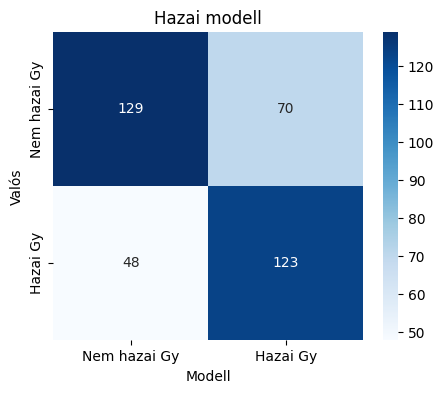

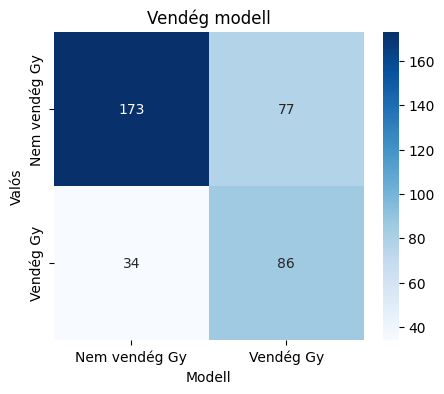

Legjobb küszöbérték a validációs halmazon: 0.22


In [433]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


test_predictions_pl, logreg_home_pl, logreg_away_pl = logreg_final(premier_league,
                                                                   drop_cols_home, drop_cols_away,
                                                                   odds,
                                                                   premier_league_params_home,premier_league_params_away)

In [434]:
def process_predictions(df):
    df = df.dropna()

    df.loc[:, 'FTR'] = 0  
    df.loc[df['target_home_win'] == 1, 'FTR'] = 1  
    df.loc[df['target_away_win'] == 1, 'FTR'] = 2  

    df.loc[:, 'test_pred_numeric_hard'] = 0
    df.loc[df['test_pred_hard'] == "Home Win", 'test_pred_numeric_hard'] = 1  
    df.loc[df['test_pred_hard'] == "Away Win", 'test_pred_numeric_hard'] = 2 
    df.loc[df['test_pred_hard'] == "Draw", 'test_pred_numeric_hard'] = 0  

    df.loc[:, 'test_pred_numeric_soft'] = 0
    df.loc[df['test_pred_soft'] == "Home Win", 'test_pred_numeric_soft'] = 1  
    df.loc[df['test_pred_soft'] == "Away Win", 'test_pred_numeric_soft'] = 2 
    df.loc[df['test_pred_soft'] == "Draw", 'test_pred_numeric_soft'] = 0 

    selected_columns = [
        'target_home_win', 'target_away_win', 'target_draw', 'FTR',
        'test_pred_hard', 'test_pred_soft',
        'test_pred_numeric_hard', 'test_pred_numeric_soft'
    ]
    result_df = df[selected_columns]

    pred_odds = df[['FTR', 'test_pred_numeric_hard', 'test_pred_numeric_soft',
                    'HomeW_odds_market',
                    'AwayW_odds_market',
                    'Draw_odds_market']]


    return pred_odds

pred_odds_pl = process_predictions(test_predictions_pl)

In [752]:
def evaluation(pred_odds):
    # print("Summary for HARD VOTING model")
    cm_hard = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    # plt.figure(figsize=(4, 3))
    # sns.heatmap(cm_hard, annot=True, fmt="d", cmap="Blues", 
    #             xticklabels=['X', 'Hazai GY', 'Idegen GY'], 
    #             yticklabels=['X', 'Hazai GY', 'Idegen GY'])
    # plt.xlabel("Modell")
    # plt.ylabel("Valós")
    # plt.title("Konfúziós mx (Hard Voting)")
    # plt.show()
    accuracy_hard = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    # report_hard = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"], digits=4)
    # print(report_hard)

    # print("\nSummary for SOFT VOTING model")
    cm_soft = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    # plt.figure(figsize=(4, 3))
    # sns.heatmap(cm_soft, annot=True, fmt="d", cmap="Blues", 
    #             xticklabels=['X', 'Hazai GY', 'Vendég GY'], 
    #             yticklabels=['X', 'Hazai GY', 'Vendég GY'])
    # plt.xlabel("Modell")
    # plt.ylabel("Valós")
    # plt.title("Konfúziós mx (Soft Voting)")
    # plt.show()
    accuracy_soft = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    # report_soft = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"], digits=4)
    # print(report_soft)

evaluation(pred_odds_pl)

In [436]:
def betting_logreg(df, stake=500):

    """
    Ezzel a fügvénnyel számolom ki a befektetés kamatát.
    Ezt külön megteszem a hard és a soft votingra.
    A tét fix, ezen lehet javítani valamilyen közgazdaságtanból származtatott optimalizálással.
    A profit definíciója a következő:
    
        (tét * historikus szorzó) - tét
    Felszummázzuk, majd a százalékos ROI-t a következőképpen kapjuk meg:
    
        (egyes meccsek profitjai felszummázva / összes elköltött pénz) * 100
    """
    df = df.copy() 

    df['Profit_hard'] = 0
    df['Profit_hard'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_hard'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_hard = df['Profit_hard'].sum()
    total_bets = len(df)

    roi_hard = (total_profit_hard / (total_bets * stake)) * 100
    
    print(f"ROI hard : {roi_hard:.2f}%")

    df['Profit_soft'] = 0
    df['Profit_soft'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_soft'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_soft = df['Profit_soft'].sum()
    total_bets = len(df)

    roi_soft = (total_profit_soft / (total_bets * stake)) * 100

    print(f"ROI soft : {roi_soft:.2f}%")

    df_profit_hard = df[df['FTR'] == df['test_pred_numeric_hard']]
    df_loss_hard = df[df['FTR'] != df['test_pred_numeric_hard']]
    
    df_profit_soft = df[df['FTR'] == df['test_pred_numeric_soft']]
    df_loss_soft = df[df['FTR'] != df['test_pred_numeric_soft']]

    return roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,df

roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(pred_odds_pl,
                                                                                                                  stake=1)

ROI hard : 2.10%
ROI soft : 3.17%


Válassz(1 vagy 2):
1 - Hard votingos ROI
2 - Soft votingos ROI
 2


>0% profit 22 fordulóban


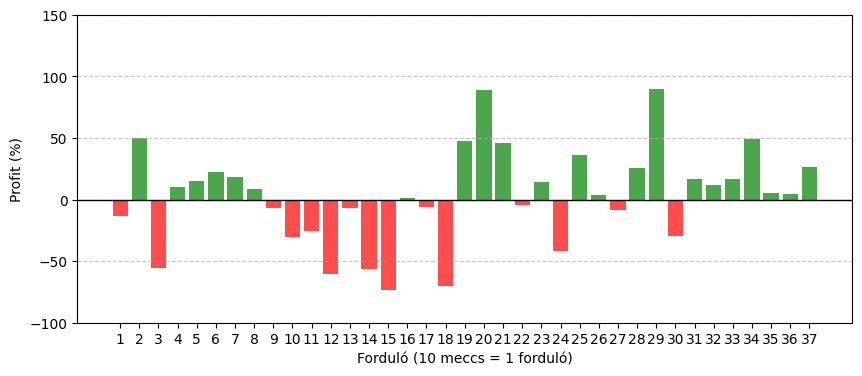

In [439]:
def ROI_sim_per_round(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    valasztas = input("Válassz(1 vagy 2):\n1 - Hard votingos ROI\n2 - Soft votingos ROI\n")
    if valasztas == "1":
        profit_column = "Profit_hard"
    elif valasztas == "2":
        profit_column = "Profit_soft"
    else:
        print("Csak 1 vagy 2 lehet az input")
        return
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({profit_column: 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round[profit_column] / (roi_per_round['Total_Bets'] * stake)) * 100

        
    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    # plt.title(f'Fogadási szimuláció, 2023-2024-es teszt szezon')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 150)  # Set y-axis limit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(r'abrak/PL_soft_ROI.jpg', format='jpg', dpi=300)
    # plt.savefig(r'abrak/PL_hard_ROI_logreg.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_per_round(pred_odds_soft, round_size=10)

## Bundesliga, FTR

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)
Accuracy: 0.6296
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       156
           1       0.61      0.62      0.62       141

    accuracy                           0.63       297
   macro avg       0.63      0.63      0.63       297
weighted avg       0.63      0.63      0.63       297



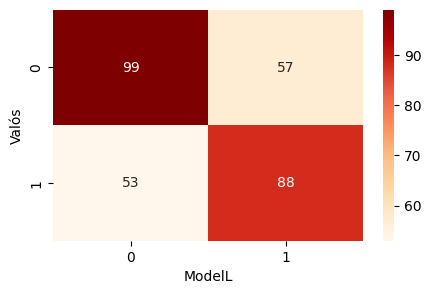

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_deep_completions_RA', 'away_cumulative_goals_diff', 'GD_diff', 'away_np_xg_difference_RA', 'home_np_xg_difference_RA', 'away_shots_RA', 'home_halftime_goals_RA', 'draw_rate_diff', 'away_ppda_RA', 'away_halftime_goals_RA', 'home_points_cumulative', 'home_last5_under_2_5_count', 'home_shots_OT_RA', 'home_shots_RA', 'home_ppda_RA', 'home_goals_against_RA', 'away_deep_completions_RA', 'home_np_xg_RA']


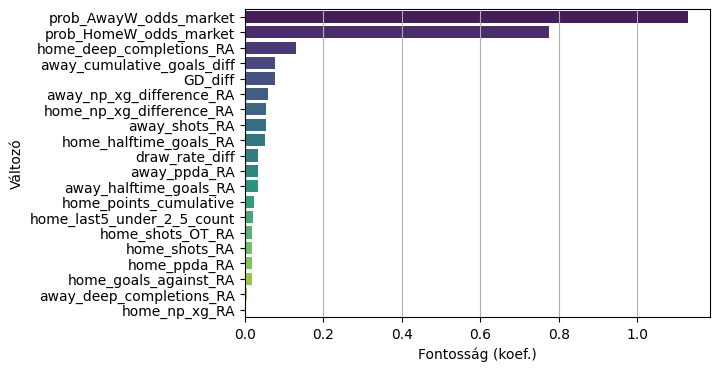

In [441]:
# target_col = 'target_home_win'
# drop = ['target_o2.5', 'target_away_win', 'target_draw']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

bundesliga_tuned_home, bundesliga_params_home, bundesliga_features_away = logistic_regression_tuning(
    bundesliga,
    target_col,
    drop,
    odds)

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)
Accuracy: 0.6330
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       214
           1       0.40      0.59      0.47        83

    accuracy                           0.63       297
   macro avg       0.60      0.62      0.60       297
weighted avg       0.69      0.63      0.65       297



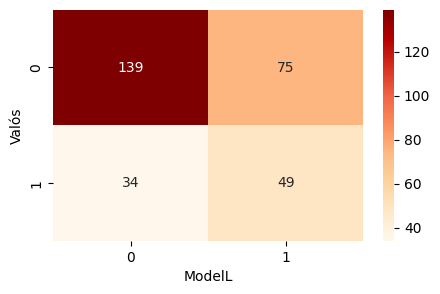

['GD_diff', 'prob_HomeW_odds_market', 'away_np_xg_difference_RA', 'away_deep_completions_RA', 'home_shots_OT_RA', 'home_deep_completions_RA', 'home_np_xg_difference_RA', 'home_expected_points_RA', 'home_clinicality', 'home_ppda_RA', 'away_cumulative_goals_diff', 'home_xg_RA', 'home_np_xg_RA', 'home_cumulative_goals_diff', 'home_last5_wins_count', 'home_last5_losses_count', 'home_last5_draws_count', 'home_last5_over_2_5_count', 'home_last5_under_2_5_count', 'home_last5_win_rate']


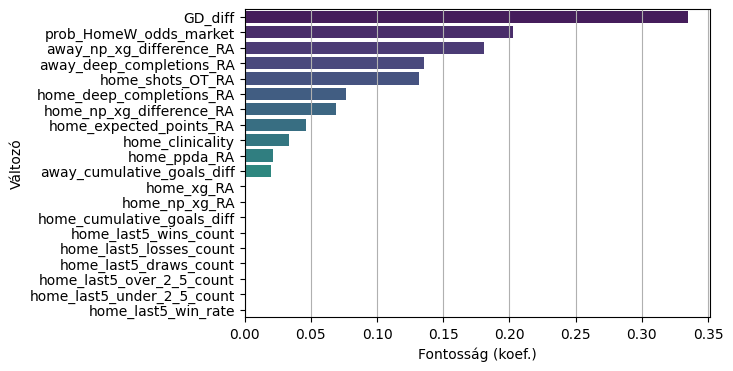

In [442]:
# target_col = 'target_away_win'
# drop = ['target_o2.5', 'target_home_win', 'target_draw']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

bundesliga_tuned_away, bundesliga_params_away, bundesliga_features_away = logistic_regression_tuning(bundesliga,
                                                                           target_col,
                                                                           drop,
                                                                           odds)

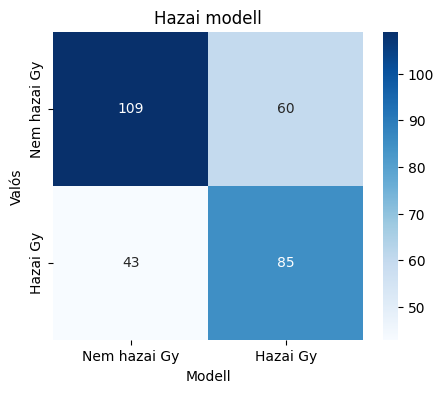

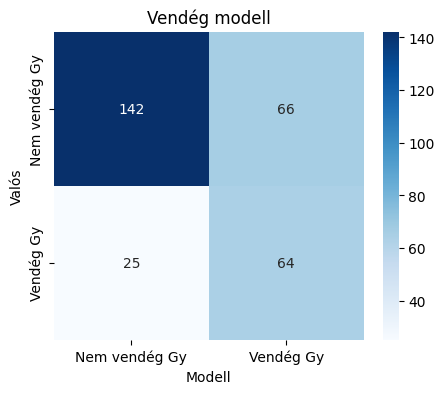

Legjobb küszöbérték a validációs halmazon: 0.18


In [443]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


test_predictions_bundesliga, logreg_home_bundesliga, logreg_away_bundesliga = logreg_final(
    bundesliga, drop_cols_home, drop_cols_away, odds, bundesliga_params_home, bundesliga_params_away
)

Summary for HARD VOTING model


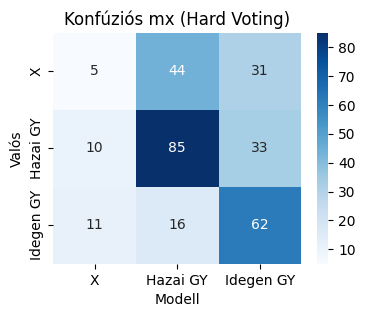

              precision    recall  f1-score   support

           0     0.1923    0.0625    0.0943        80
           1     0.5862    0.6641    0.6227       128
           2     0.4921    0.6966    0.5767        89

    accuracy                         0.5118       297
   macro avg     0.4235    0.4744    0.4313       297
weighted avg     0.4519    0.5118    0.4666       297


Summary for SOFT VOTING model


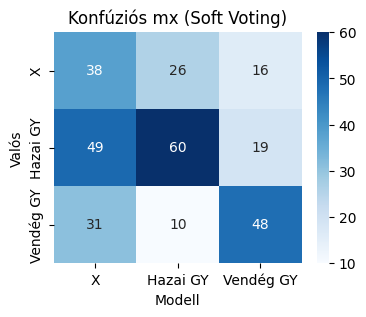

              precision    recall  f1-score   support

           0     0.3220    0.4750    0.3838        80
           1     0.6250    0.4688    0.5357       128
           2     0.5783    0.5393    0.5581        89

    accuracy                         0.4916       297
   macro avg     0.5084    0.4944    0.4926       297
weighted avg     0.5294    0.4916    0.5015       297



In [444]:
pred_odds_bundesliga = process_predictions(test_predictions_bundesliga)
evaluation(pred_odds_bundesliga)

In [445]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(
    pred_odds_bundesliga,
    stake=500)

ROI hard : -5.38%
ROI soft : 5.24%


## Serie A, FTR

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)
Accuracy: 0.6257
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       205
           1       0.55      0.63      0.59       153

    accuracy                           0.63       358
   macro avg       0.62      0.63      0.62       358
weighted avg       0.63      0.63      0.63       358



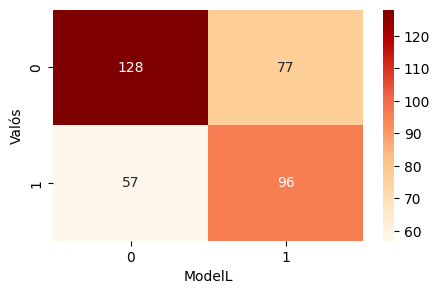

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_np_xg_RA', 'cumulative_points_diff', 'home_last5_draws_count', 'home_xg_RA', 'home_goals_against_RA', 'away_cumulative_goals_diff', 'home_np_xg_difference_RA', 'home_shots_OT_RA', 'away_np_xg_difference_RA', 'home_last5_draw_rate', 'home_last5_lose_rate', 'away_last5_over_2_5_count', 'away_points_cumulative', 'home_deep_completions_RA', 'away_ppda_RA', 'away_last5_wins_count', 'home_clinicality', 'home_last5_under_2_5_count']


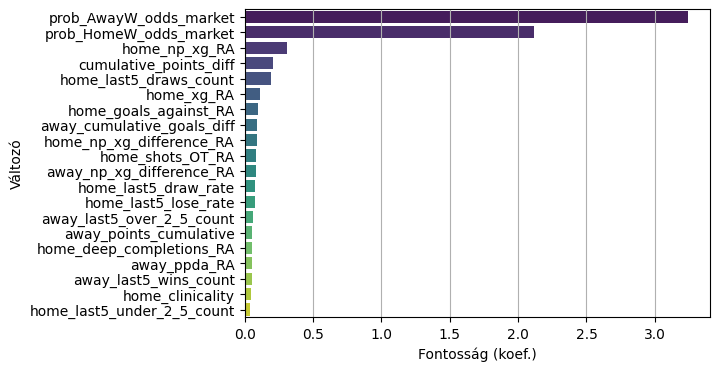

In [446]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

serie_a_tuned_home, serie_a_params_home, serie_a_features_home = logistic_regression_tuning(serie_a, target_col, drop, odds)

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)
Accuracy: 0.6508
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       245
           1       0.46      0.63      0.53       113

    accuracy                           0.65       358
   macro avg       0.63      0.64      0.63       358
weighted avg       0.69      0.65      0.66       358



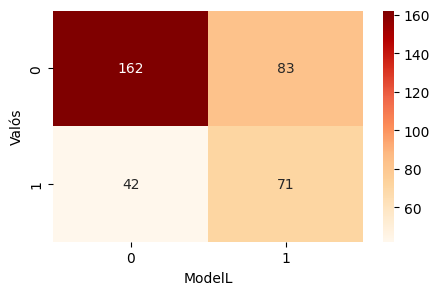

['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'home_np_xg_RA', 'home_shots_OT_RA', 'home_halftime_goals_RA', 'away_last5_over_2_5_count', 'home_expected_points_RA', 'away_cumulative_goals_diff', 'away_np_xg_difference_RA', 'away_last5_wins_count', 'home_last5_wins_count', 'home_ppda_RA', 'home_np_xg_difference_RA', 'away_goals_for_RA', 'away_total_goals_RA', 'away_last5_under_2_5_count', 'home_shots_RA', 'home_last5_over_2_5_count', 'away_shots_OT_RA', 'home_deep_completions_RA']


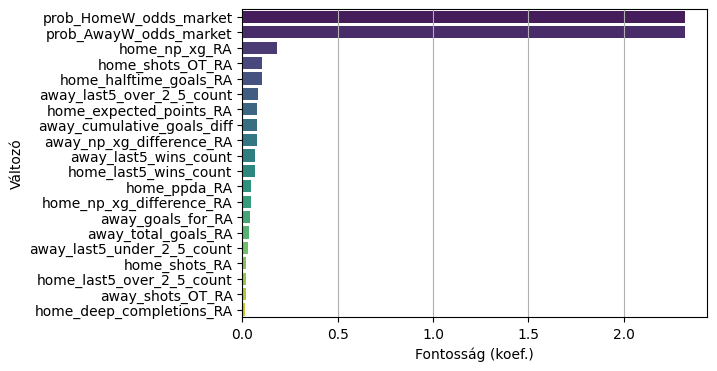

In [447]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

serie_a_tuned_away, serie_a_params_away, serie_a_features_away = logistic_regression_tuning(serie_a, target_col, drop, odds)

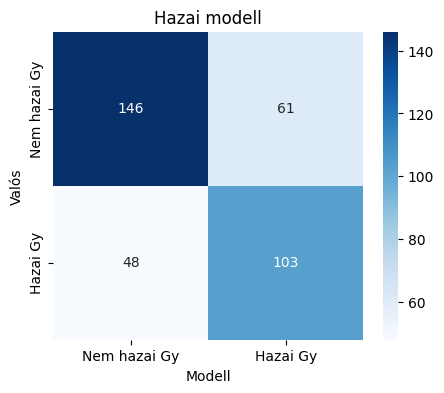

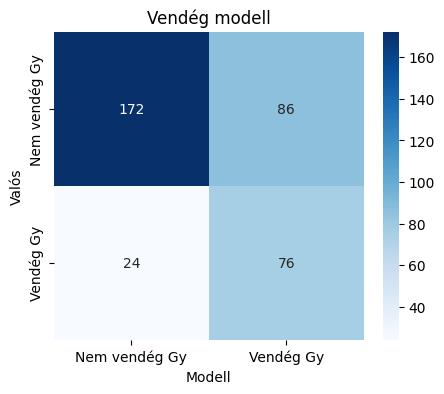

Legjobb küszöbérték a validációs halmazon: 0.19


In [448]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_serie_a, logreg_home_serie_a, logreg_away_serie_a = logreg_final(
    serie_a, drop_cols_home, drop_cols_away, odds, serie_a_params_home, serie_a_params_away
)


Summary for HARD VOTING model


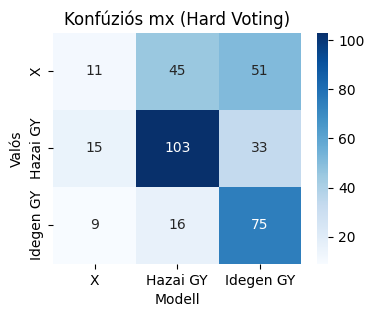

              precision    recall  f1-score   support

           0     0.3143    0.1028    0.1549       107
           1     0.6280    0.6821    0.6540       151
           2     0.4717    0.7500    0.5792       100

    accuracy                         0.5279       358
   macro avg     0.4713    0.5116    0.4627       358
weighted avg     0.4906    0.5279    0.4839       358


Summary for SOFT VOTING model


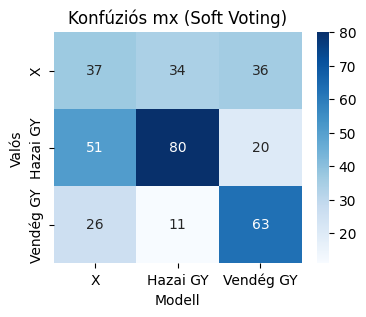

              precision    recall  f1-score   support

           0     0.3246    0.3458    0.3348       107
           1     0.6400    0.5298    0.5797       151
           2     0.5294    0.6300    0.5753       100

    accuracy                         0.5028       358
   macro avg     0.4980    0.5019    0.4966       358
weighted avg     0.5148    0.5028    0.5053       358



In [449]:
pred_odds_serie_a = process_predictions(test_predictions_serie_a)
evaluation(pred_odds_serie_a)

In [450]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(
    pred_odds_serie_a,
    stake=500)

ROI hard : 1.99%
ROI soft : 2.72%


## La Liga, FTR

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
Accuracy: 0.6162
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       191
           1       0.61      0.59      0.60       179

    accuracy                           0.62       370
   macro avg       0.62      0.62      0.62       370
weighted avg       0.62      0.62      0.62       370



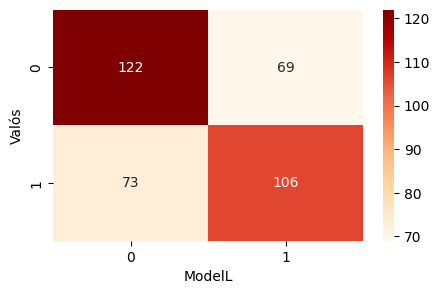

['GD_diff', 'cumulative_points_diff', 'away_cumulative_goals_diff', 'home_deep_completions_RA', 'away_deep_completions_RA', 'home_cumulative_goals_diff', 'prob_HomeW_odds_market', 'home_shots_OT_RA', 'home_expected_points_RA', 'prob_AwayW_odds_market', 'home_ppda_RA', 'home_np_xg_difference_RA', 'home_points_cumulative', 'away_np_xg_RA', 'home_shots_RA', 'away_expected_points_RA', 'home_np_xg_RA', 'away_np_xg_difference_RA', 'away_xg_RA', 'away_points_cumulative']


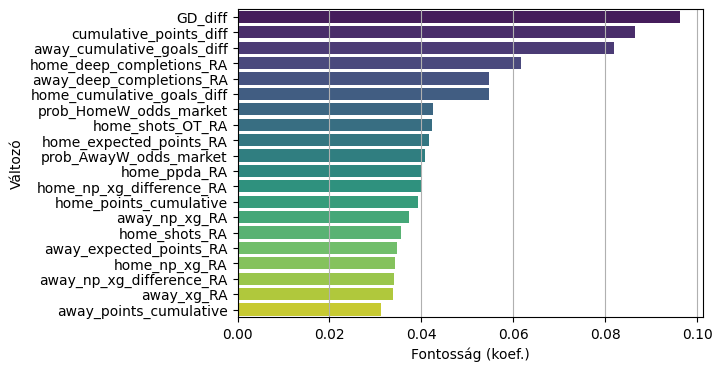

In [451]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

la_liga_tuned_home, la_liga_params_home, la_liga_features_home = logistic_regression_tuning(la_liga, target_col, drop, odds)

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
Accuracy: 0.6541
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       265
           1       0.43      0.66      0.52       105

    accuracy                           0.65       370
   macro avg       0.63      0.65      0.62       370
weighted avg       0.71      0.65      0.67       370



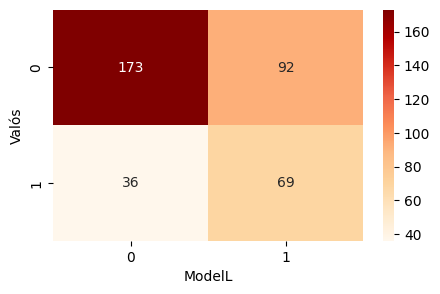

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'away_last5_draw_rate', 'home_goals_for_RA', 'home_expected_points_RA', 'away_last5_draws_count', 'home_np_xg_difference_RA', 'home_clinicality', 'prob_Draw_odds_market', 'home_last5_under_2_5_count', 'home_halftime_goals_RA', 'away_cumulative_goals_diff', 'away_clinicality', 'away_goals_against_RA', 'away_np_xg_RA', 'home_last5_draw_rate', 'away_goals_for_RA', 'home_shots_RA', 'home_xg_RA', 'away_halftime_goals_RA']


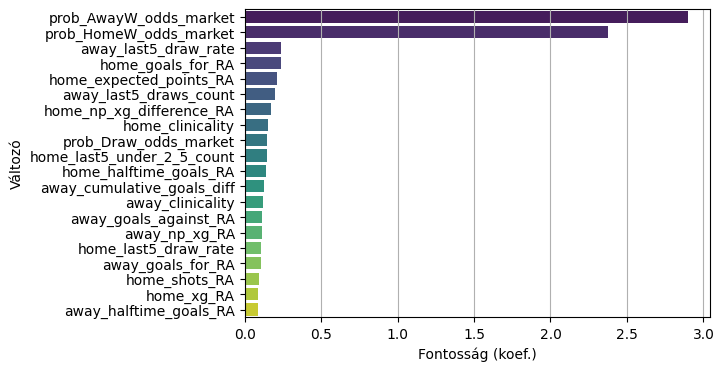

In [452]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']


target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

la_liga_tuned_away, la_liga_params_away,la_liga_features_away = logistic_regression_tuning(la_liga, target_col, drop, odds)

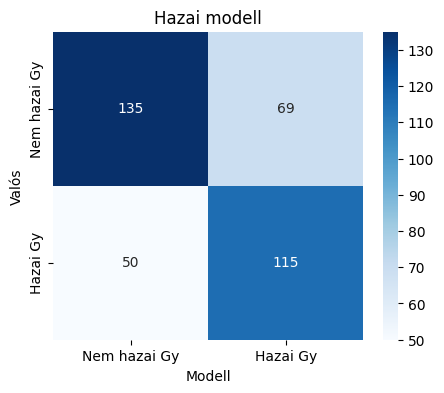

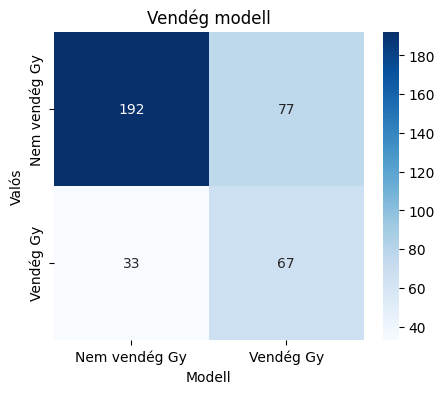

Legjobb küszöbérték a validációs halmazon: 0.12


In [453]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_la_liga, logreg_home_la_liga, logreg_away_la_liga = logreg_final(
    la_liga, drop_cols_home, drop_cols_away, odds, la_liga_params_home, la_liga_params_away
)

Summary for HARD VOTING model


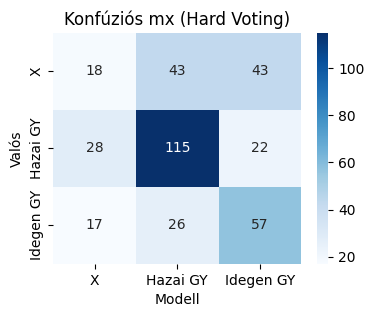

              precision    recall  f1-score   support

           0     0.2857    0.1731    0.2156       104
           1     0.6250    0.6970    0.6590       165
           2     0.4672    0.5700    0.5135       100

    accuracy                         0.5149       369
   macro avg     0.4593    0.4800    0.4627       369
weighted avg     0.4866    0.5149    0.4946       369


Summary for SOFT VOTING model


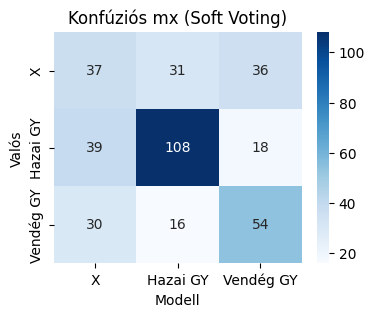

              precision    recall  f1-score   support

           0     0.3491    0.3558    0.3524       104
           1     0.6968    0.6545    0.6750       165
           2     0.5000    0.5400    0.5192       100

    accuracy                         0.5393       369
   macro avg     0.5153    0.5168    0.5155       369
weighted avg     0.5454    0.5393    0.5419       369



In [454]:
pred_odds_la_liga = process_predictions(test_predictions_la_liga)
evaluation(pred_odds_la_liga)

In [455]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(
    pred_odds_la_liga,
    stake=500)

ROI hard : 0.24%
ROI soft : 10.09%


## Ligue 1, FTR

tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)
Accuracy: 0.6591
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       205
           1       0.58      0.69      0.63       147

    accuracy                           0.66       352
   macro avg       0.66      0.66      0.66       352
weighted avg       0.67      0.66      0.66       352



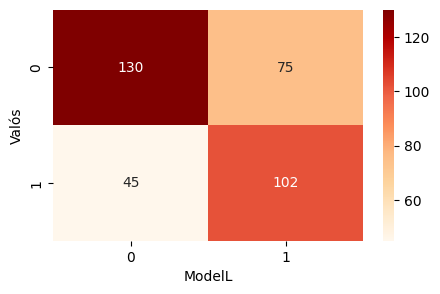

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'home_last5_over_2_5_count', 'away_last5_over_2_5_count', 'home_goals_for_RA', 'home_last5_under_2_5_count', 'away_last5_under_2_5_count', 'home_clinicality', 'away_last5_draws_count', 'away_expected_points_RA', 'home_last5_draws_count', 'away_np_xg_RA', 'home_last5_wins_count', 'away_last5_losses_count', 'home_last5_losses_count', 'home_xg_RA', 'away_last5_wins_count', 'away_clinicality']


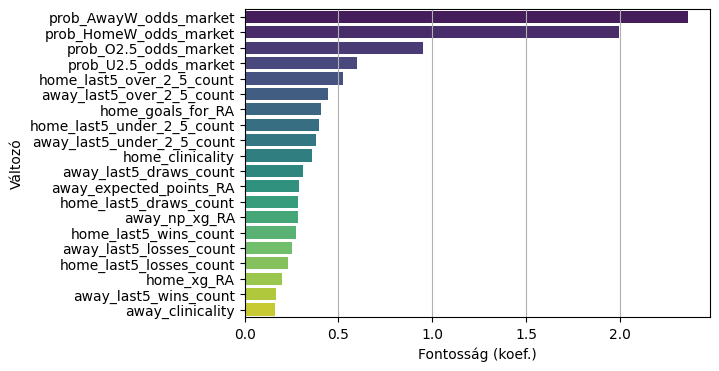

In [456]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

ligue_1_tuned_home, ligue_1_params_home, ligue_1_features_home = logistic_regression_tuning(ligue_1, target_col, drop, odds)

tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       233
           1       0.53      0.66      0.59       119

    accuracy                           0.69       352
   macro avg       0.67      0.68      0.67       352
weighted avg       0.71      0.69      0.69       352



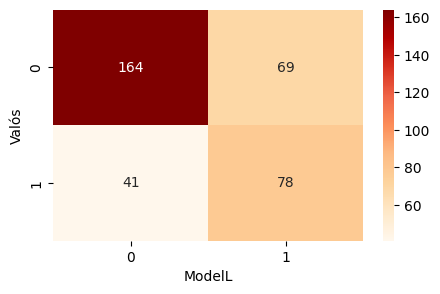

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_goals_for_RA', 'prob_U2.5_odds_market', 'home_clinicality', 'away_goals_for_RA', 'home_xg_RA', 'away_last5_losses_count', 'away_cumulative_goals_diff', 'away_last5_draw_rate', 'home_deep_completions_RA', 'away_expected_points_RA', 'home_np_xg_RA', 'away_xg_RA', 'away_np_xg_RA', 'away_deep_completions_RA', 'away_last5_draws_count', 'home_last5_wins_count', 'home_expected_points_RA', 'home_last5_draws_count']


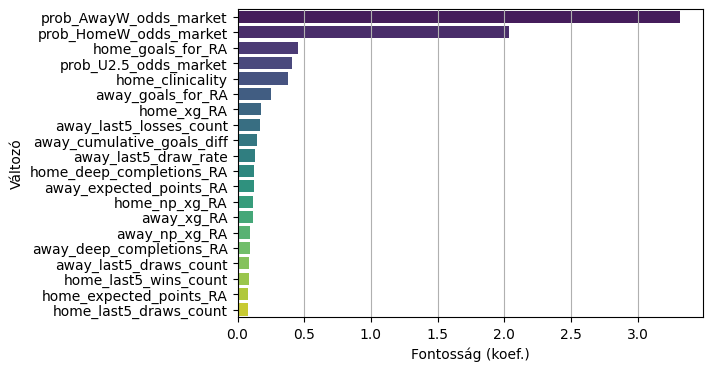

In [457]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

ligue_1_tuned_away, ligue_1_params_away, ligue_1_features_away = logistic_regression_tuning(ligue_1, target_col, drop, odds)

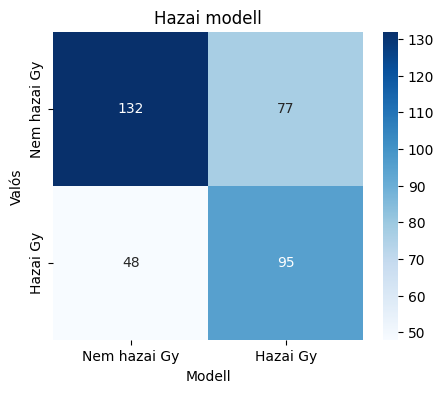

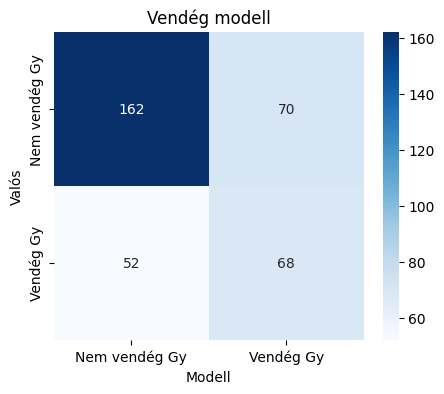

Legjobb küszöbérték a validációs halmazon: 0.07


In [458]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_ligue_1, logreg_home_ligue_1, logreg_away_ligue_1 = logreg_final(
    ligue_1, drop_cols_home, drop_cols_away, odds, ligue_1_params_home, ligue_1_params_away
)

Summary for HARD VOTING model


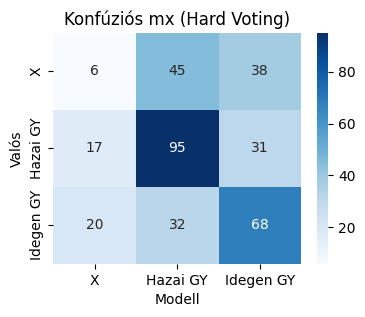

              precision    recall  f1-score   support

           0     0.1395    0.0674    0.0909        89
           1     0.5523    0.6643    0.6032       143
           2     0.4964    0.5667    0.5292       120

    accuracy                         0.4801       352
   macro avg     0.3961    0.4328    0.4078       352
weighted avg     0.4289    0.4801    0.4484       352


Summary for SOFT VOTING model


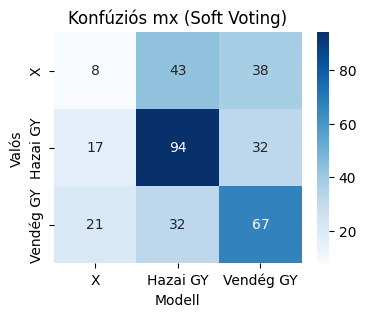

              precision    recall  f1-score   support

           0     0.1739    0.0899    0.1185        89
           1     0.5562    0.6573    0.6026       143
           2     0.4891    0.5583    0.5214       120

    accuracy                         0.4801       352
   macro avg     0.4064    0.4352    0.4142       352
weighted avg     0.4367    0.4801    0.4525       352



In [459]:
pred_odds_ligue_1 = process_predictions(test_predictions_ligue_1)
evaluation(pred_odds_ligue_1)

In [460]:
roi_hard, roi_soft, df_profit_hard, df_loss_hard, df_profit_soft, df_loss_soft, pred_odds_soft = betting_logreg(
    pred_odds_ligue_1,
    stake=500
)

ROI hard : -8.62%
ROI soft : -8.26%


## Kombinált, FTR

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)
Accuracy: 0.6552
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       949
           1       0.62      0.64      0.63       797

    accuracy                           0.66      1746
   macro avg       0.65      0.65      0.65      1746
weighted avg       0.66      0.66      0.66      1746



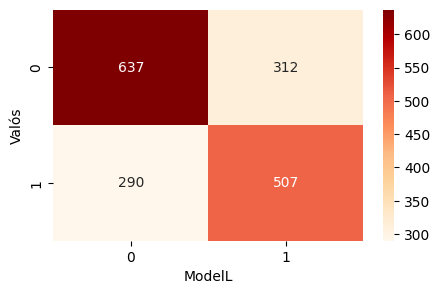

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'prob_U2.5_odds_market', 'home_np_xg_difference_RA', 'away_expected_points_RA', 'away_cumulative_goals_diff', 'away_np_xg_RA', 'home_np_xg_RA', 'home_last5_under_2_5_count', 'home_halftime_goals_RA', 'away_last5_over_2_5_count', 'win_rate_diff', 'away_last5_wins_count', 'away_points_cumulative', 'home_shots_OT_RA', 'home_ppda_RA', 'home_last5_losses_count', 'home_last5_over_2_5_count', 'GD_diff', 'away_deep_completions_RA']


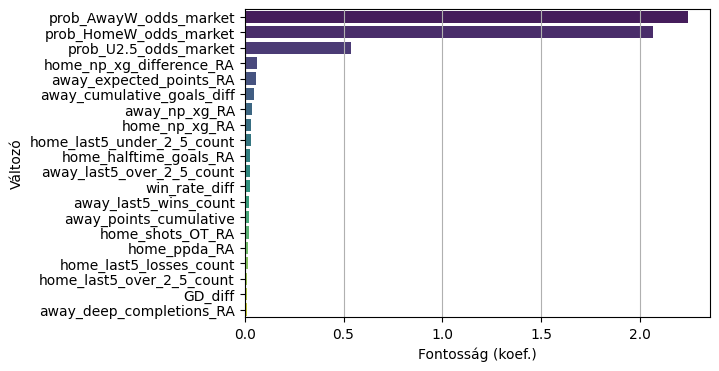

In [461]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

big5_tuned_home, big5_params_home, big5_features_home = logistic_regression_tuning(big5, target_col, drop, odds)

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)
Accuracy: 0.6466
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1222
           1       0.44      0.65      0.52       524

    accuracy                           0.65      1746
   macro avg       0.63      0.65      0.62      1746
weighted avg       0.70      0.65      0.66      1746



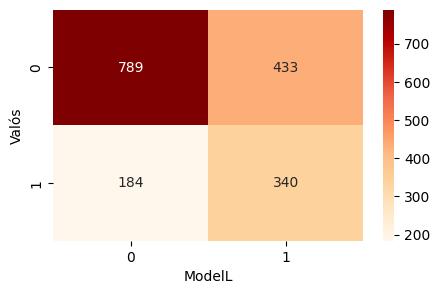

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_clinicality', 'away_cumulative_goals_diff', 'away_last5_losses_count', 'home_shots_OT_RA', 'away_last5_draw_rate', 'away_goals_for_RA', 'home_last5_under_2_5_count', 'home_last5_losses_count', 'away_np_xg_difference_RA', 'home_expected_points_RA', 'home_deep_completions_RA', 'home_np_xg_difference_RA', 'away_last5_draws_count', 'away_last5_wins_count', 'away_ppda_RA', 'home_halftime_goals_RA', 'away_expected_points_RA', 'home_shots_RA']


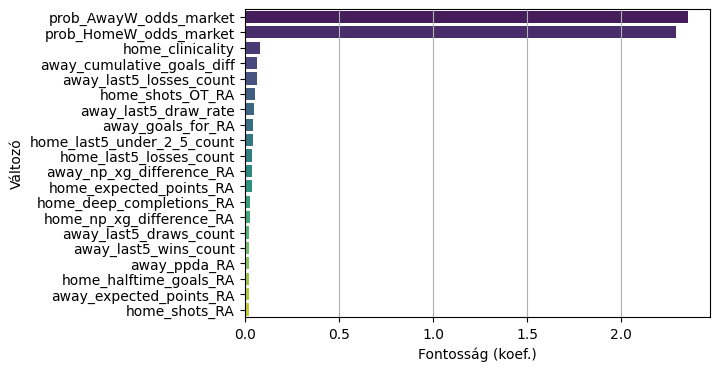

In [462]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

big5_tuned_away, big5_params_away, big5_features_away = logistic_regression_tuning(big5, target_col, drop, odds)

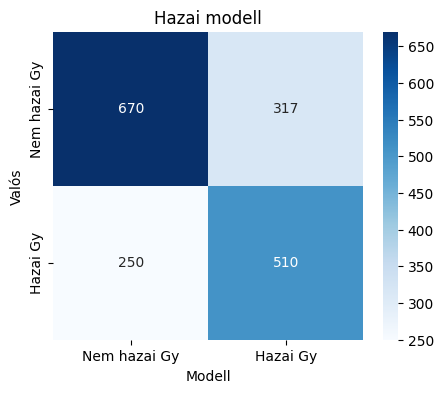

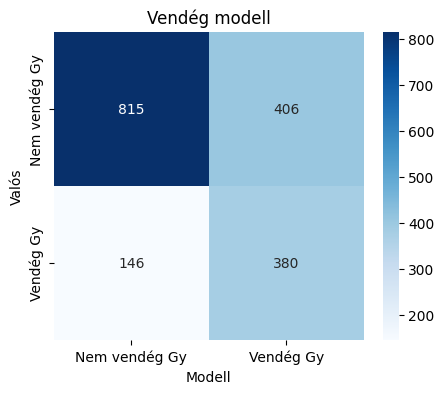

Legjobb küszöbérték a validációs halmazon: 0.20


In [463]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_big5, logreg_home_big5, logreg_away_big5 = logreg_final(
    big5, drop_cols_home, drop_cols_away, odds, big5_params_home, big5_params_away
)

Summary for HARD VOTING model


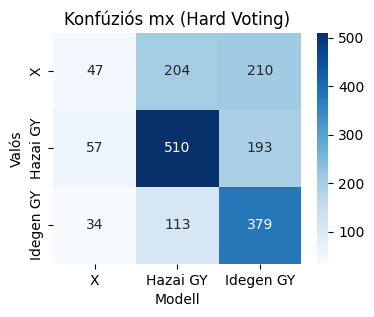

              precision    recall  f1-score   support

           0     0.3406    0.1020    0.1569       461
           1     0.6167    0.6711    0.6427       760
           2     0.4847    0.7205    0.5795       526

    accuracy                         0.5358      1747
   macro avg     0.4806    0.4978    0.4597      1747
weighted avg     0.5041    0.5358    0.4955      1747


Summary for SOFT VOTING model


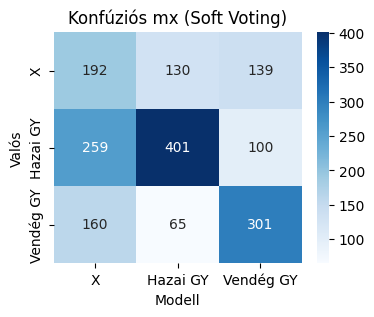

              precision    recall  f1-score   support

           0     0.3142    0.4165    0.3582       461
           1     0.6728    0.5276    0.5914       760
           2     0.5574    0.5722    0.5647       526

    accuracy                         0.5117      1747
   macro avg     0.5148    0.5055    0.5048      1747
weighted avg     0.5434    0.5117    0.5219      1747



In [464]:
pred_odds_big5 = process_predictions(test_predictions_big5)
evaluation(pred_odds_big5)

In [465]:
roi_hard, roi_soft, df_profit_hard, df_loss_hard, df_profit_soft, df_loss_soft, pred_odds_soft = betting_logreg(
    pred_odds_big5,
    stake=500
)

ROI hard : 1.38%
ROI soft : 4.83%


# U/O 2.5

## PL

In [7]:
def logistic_regression_tuning_underover(df, target_col, drop_cols=[], odds=[]):

    df = df.dropna().reset_index(drop=True)

    train_n = int(len(df) * 0.8) 
    val_n = int(len(df) * 0.1)    
    
    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:]  

    print(f"\nTanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"Validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")
    print(f"Teszt halmaz:  (i: {test_set.index[0]+1} -> {test_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]
    X_test, y_test = test_set.drop(columns=[target_col] + drop_cols), test_set[target_col]

    X_train_odds = X_train[odds] if odds else pd.DataFrame(index=X_train.index)
    X_val_odds = X_val[odds] if odds else pd.DataFrame(index=X_val.index)
    X_test_odds = X_test[odds] if odds else pd.DataFrame(index=X_test.index)
    
    if odds:
        X_train = X_train.drop(columns=odds)
        X_val = X_val.drop(columns=odds)
        X_test = X_test.drop(columns=odds)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
    X_val_scaled = pd.concat([X_val_scaled, X_val_odds], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, X_test_odds], axis=1)
    
    param_space = [
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l1'],
         'solver': ['liblinear', 'saga'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l2'],
         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['elasticnet'],
         'solver': ['saga'],  
         'l1_ratio': Real(0, 1),
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    ]

    tscv = TimeSeriesSplit(n_splits=5) 
    
    log_reg = LogisticRegression(random_state=1, max_iter=1000)

    bayes_search = BayesSearchCV(
        estimator=log_reg,
        search_spaces=param_space,
        n_iter=50, 
        cv=tscv, 
        scoring='f1',
        refit='f1',
        n_jobs=-1,  
        random_state=1,
        verbose=0
    )
    
    bayes_search.fit(X_train_scaled, y_train)  
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    
    print("\nLegjobb hiperparaméterek:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    y_val_probs = best_model.predict_proba(X_val_scaled)
    val_results = val_set.copy()
    val_results['P_0'] = y_val_probs[:, 0] 
    val_results['P_1'] = y_val_probs[:, 1]  

    thresholds = np.arange(0.1, 0.7, 0.01)
    f1_scores = []
    
    for t in thresholds:
        preds = (y_val_probs[:, 1] >= t).astype(int)
        f1_scores.append(f1_score(y_val, preds, average='macro'))
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    
    print(f"\nLegjobb threshold: {best_threshold:.2f}, Legjobb F1: {best_f1:.4f}")
    
    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, f1_scores, color='teal')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Legjobb: {best_threshold:.2f}')
    plt.xlabel("Határérték")
    plt.ylabel("Átlagos F1-érték")
    plt.grid()
    plt.legend()
    plt.title("Határérték optimalizálása a validációs halmazon")
    plt.show()

    y_val_pred = (y_val_probs[:, 1] >= best_threshold).astype(int)
    val_results['Predicted'] = y_val_pred

    print("\nValidációs halmaz eredményei:")
    print(classification_report(y_val, y_val_pred))
    
    plt.figure(figsize=(5, 3))
    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Validációs halmaz konfúziós mátrixa")
    plt.show()
    
    feature_importances = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': np.abs(best_model.coef_).flatten()
    }).sort_values(by='importance', ascending=False)
    
    top_20_features = feature_importances.head(20)['feature'].tolist()
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
    plt.xlabel("Fontosság (koef.)")
    plt.ylabel("Változó")
    plt.grid(axis='x')
    plt.title("Top 20 legfontosabb változó")
    plt.tight_layout()
    plt.show()
    
    y_test_probs = best_model.predict_proba(X_test_scaled)
    test_results = test_set.copy()
    test_results['P_0'] = y_test_probs[:, 0]
    test_results['P_1'] = y_test_probs[:, 1]
    y_test_pred = (y_test_probs[:, 1] >= best_threshold).astype(int)
    test_results['Predicted'] = y_test_pred
    
    print("\nTeszt halmaz eredményei:")
    print(classification_report(y_test, y_test_pred))
    
    plt.figure(figsize=(5, 3))
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Teszt halmaz konfúziós mátrixa")
    plt.show()
    
    return test_results, best_model, top_20_features, scaler


Tanító halmaz indexek: (i: 1 -> 2958)
Validációs halmaz:  (i: 2959 -> 3327)
Teszt halmaz:  (i: 3328 -> 3698)

Legjobb hiperparaméterek:
C: 171.3928432232203
class_weight: None
max_iter: 500
penalty: l2
solver: lbfgs

Legjobb threshold: 0.49, Legjobb F1: 0.5581


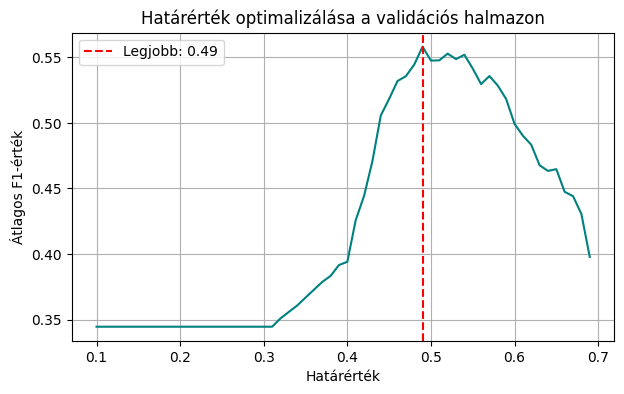


Validációs halmaz eredményei:
              precision    recall  f1-score   support

           0       0.57      0.42      0.48       175
           1       0.57      0.71      0.64       194

    accuracy                           0.57       369
   macro avg       0.57      0.56      0.56       369
weighted avg       0.57      0.57      0.56       369



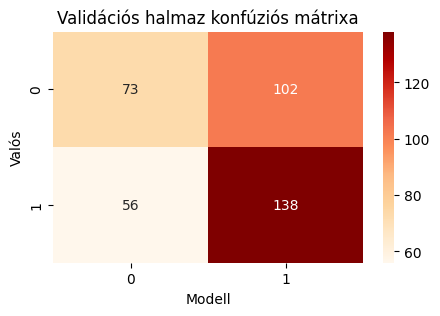

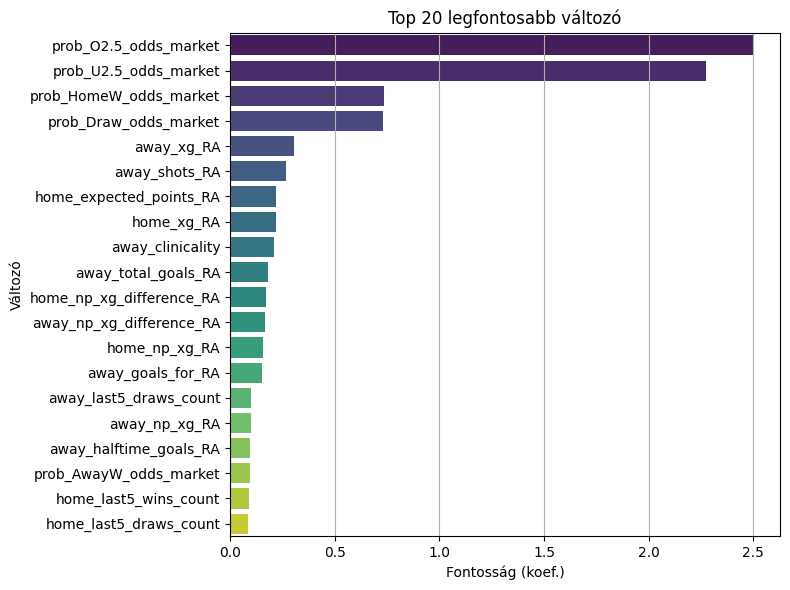


Teszt halmaz eredményei:
              precision    recall  f1-score   support

           0       0.47      0.20      0.28       129
           1       0.67      0.88      0.76       242

    accuracy                           0.64       371
   macro avg       0.57      0.54      0.52       371
weighted avg       0.60      0.64      0.60       371



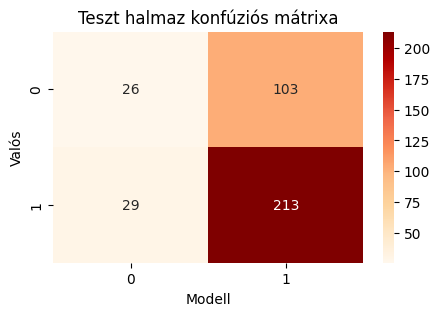

In [723]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

premier_league_tuned_UO, pl_lr_uo, premier_league_features_UO, pl_scaler_UO  = logistic_regression_tuning_underover(
    premier_league,
    target_col,
    drop,
    odds
)

In [469]:
def betting_logreg_underover(df, stake=1):
    
    df = df.copy() 

    df['Profit'] = 0
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )

    total_profit = df['Profit'].sum()
    total_bets = len(df)

    roi = (total_profit / (total_bets * stake)) * 100
    
    print(f"ROI: {roi:.2f}%")

    df_profit = df[df['target_o2.5'] == df['Predicted']]
    df_loss = df[df['target_o2.5'] != df['Predicted']]

    return roi, df_profit, df_loss, df

roi, df_profit, df_loss, pred_odds = betting_logreg_underover(premier_league_tuned_UO, stake=1)


ROI: 3.74%


>0% profit 16 fordulóban


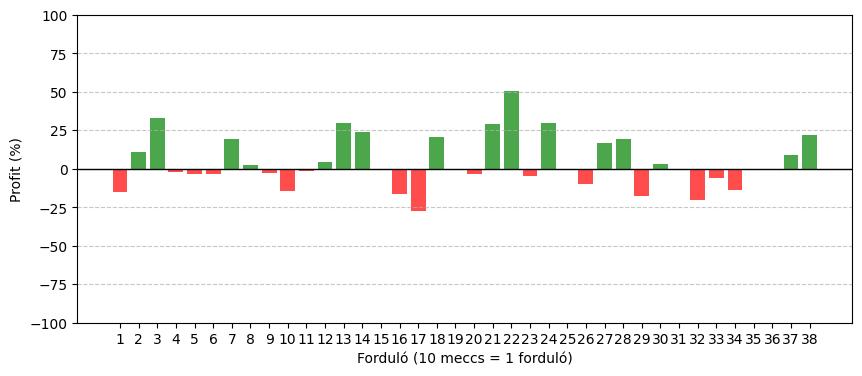

In [471]:
def ROI_sim_UO(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({'Profit': 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round['Profit'] / (roi_per_round['Total_Bets'] * stake)) * 100

    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 100)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(r'abrak/PL_ROI_UO.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_UO(premier_league_tuned_UO, round_size=10)

## Bundesliga


Tanító halmaz indexek: (i: 1 -> 2376)
Validációs halmaz:  (i: 2377 -> 2673)
Teszt halmaz:  (i: 2674 -> 2970)

Legjobb hiperparaméterek:
C: 0.012734150498152325
class_weight: None
l1_ratio: 0.48231966084731764
max_iter: 284
penalty: elasticnet
solver: saga

Legjobb threshold: 0.58, Legjobb F1: 0.5371


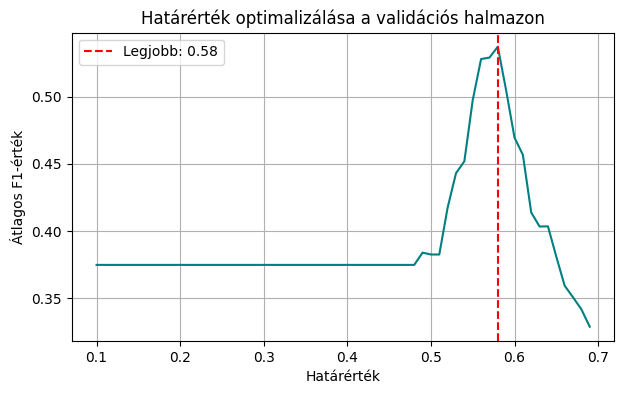


Validációs halmaz eredményei:
              precision    recall  f1-score   support

           0       0.44      0.51      0.47       119
           1       0.64      0.57      0.60       178

    accuracy                           0.55       297
   macro avg       0.54      0.54      0.54       297
weighted avg       0.56      0.55      0.55       297



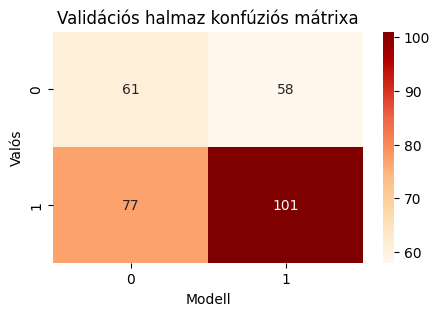

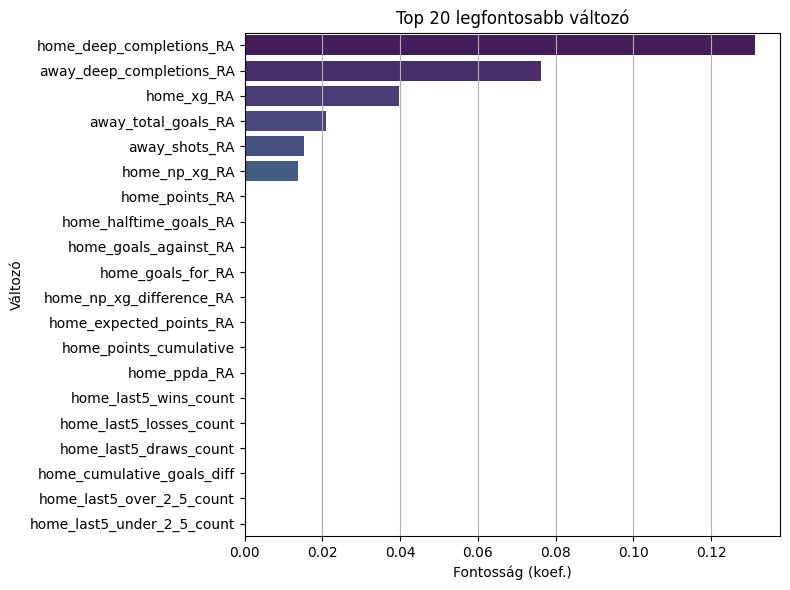


Teszt halmaz eredményei:
              precision    recall  f1-score   support

           0       0.50      0.45      0.47       112
           1       0.69      0.73      0.71       185

    accuracy                           0.62       297
   macro avg       0.59      0.59      0.59       297
weighted avg       0.62      0.62      0.62       297



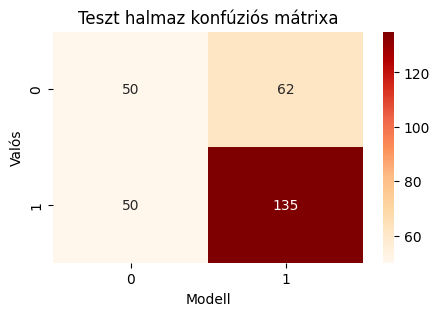

In [806]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


bundesliga_tuned_UO, gm_lr_uo, bundesliga_features_UO, bundesliga_scaler_UO = logistic_regression_tuning_underover(
    bundesliga,  
    target_col,
    drop,
    odds
)

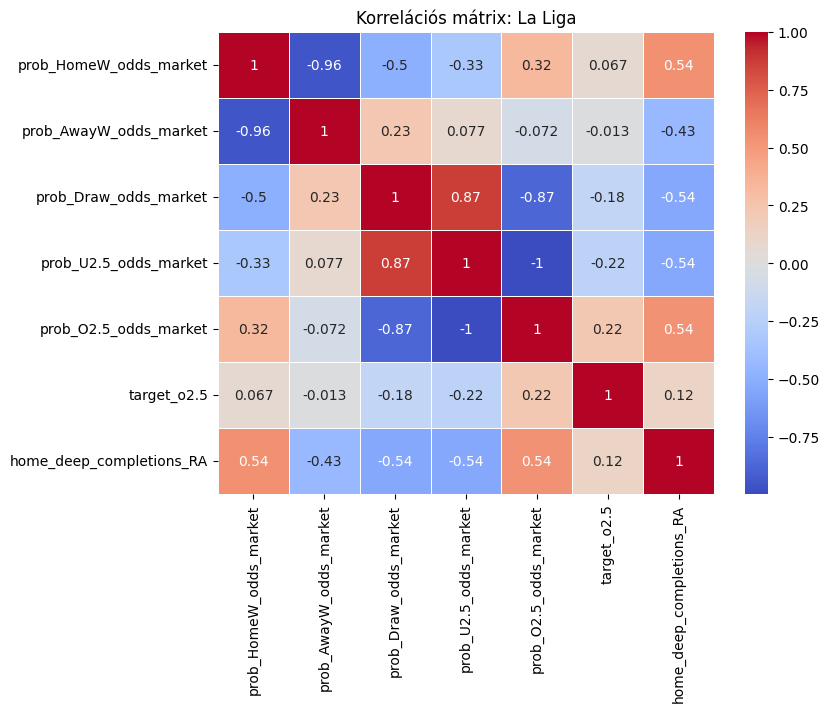

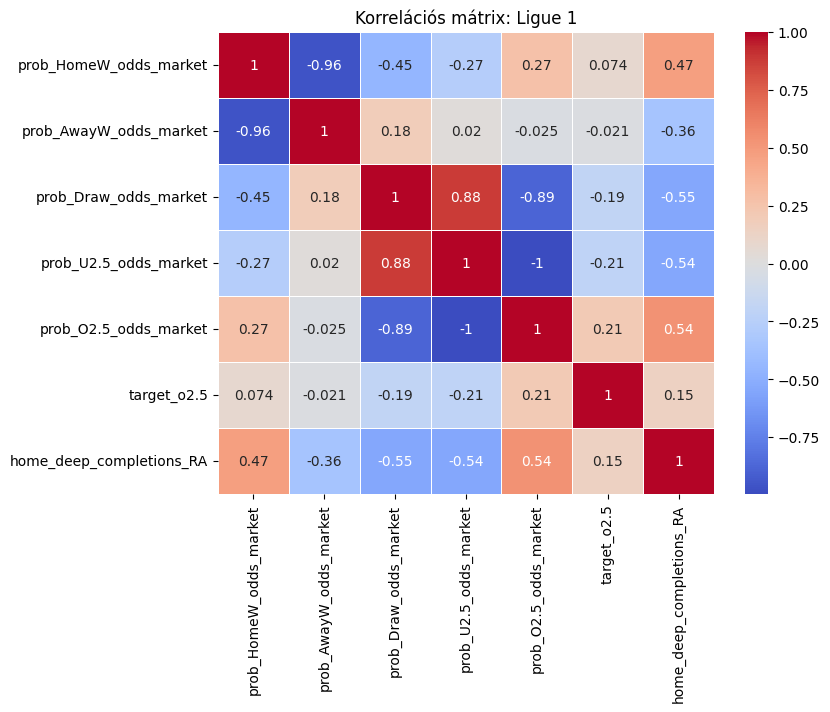

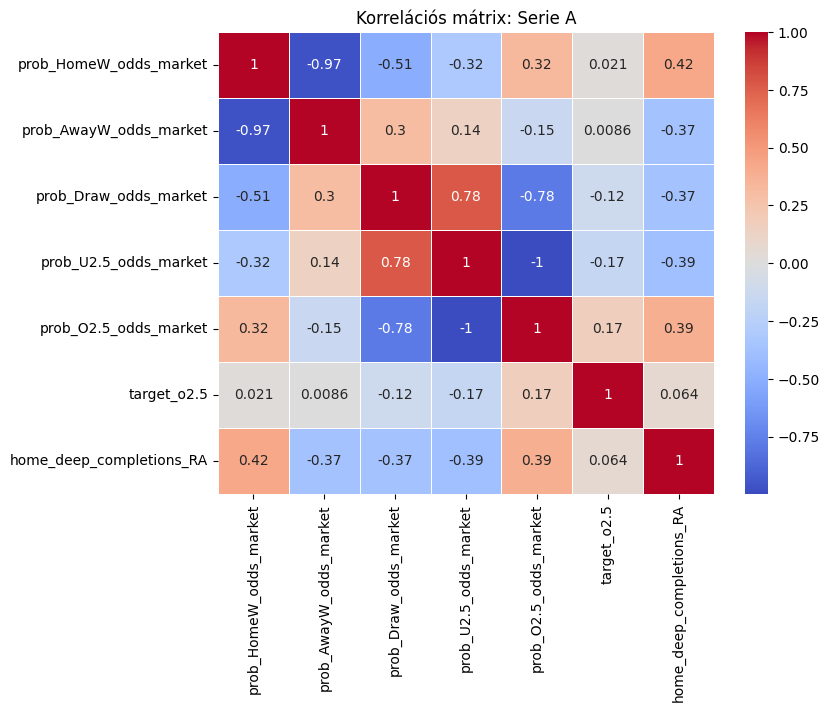

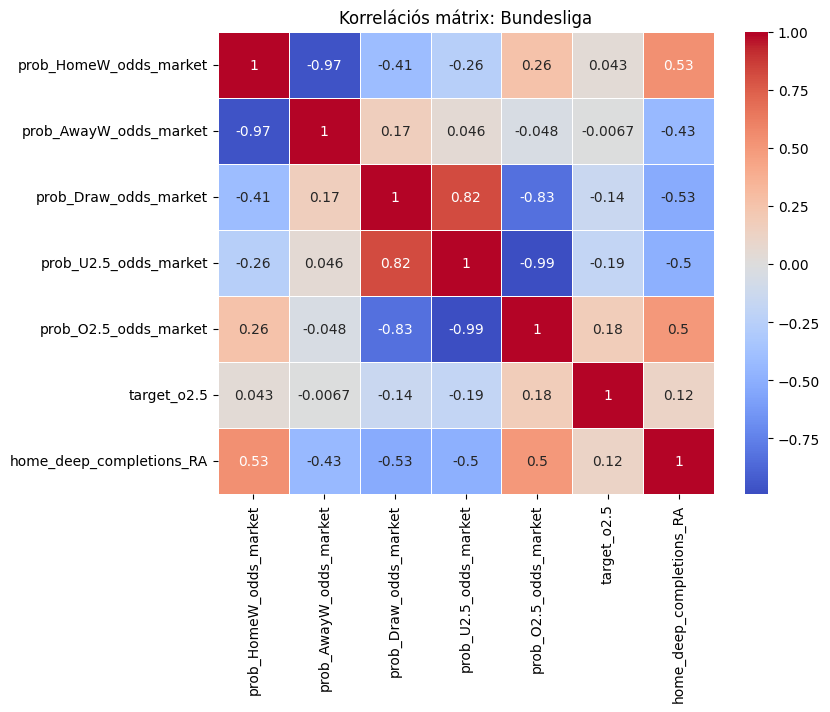

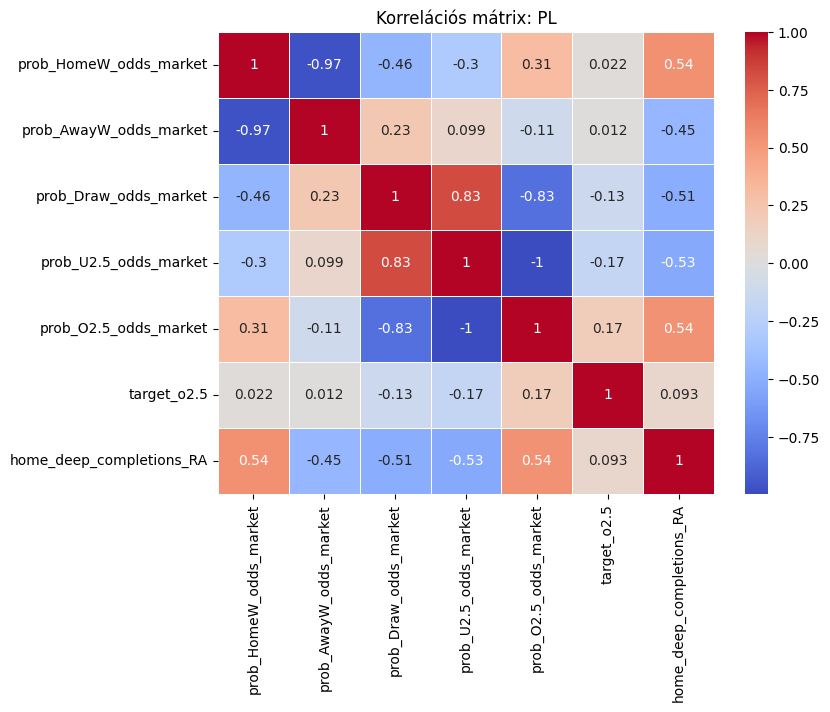

In [822]:
def plot_prob_corr_heatmaps(dfs: dict):
    """
    Megrajzolja a korrelációs hőtérképeket minden dataframe-re a dict-ben,
    csak a 'prob_'-bal kezdődő oszlopokra és a 'target_o2.5'-re.
    """
    for name, df in dfs.items():
        prob_cols = [col for col in df.columns if col.startswith('prob_') and df[col].dtype != 'object']
        if 'target_o2.5' in df.columns and df['target_o2.5'].dtype != 'object':
            prob_cols.append('target_o2.5')
        if 'home_deep_completions_RA' in df.columns and df['home_deep_completions_RA'].dtype != 'object':
            prob_cols.append('home_deep_completions_RA')

        if prob_cols:
            corr_matrix = df[prob_cols].corr()

            plt.figure(figsize=(8, 6))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, linewidths=0.5)
            plt.title(f"Korrelációs mátrix: {name}")
            plt.show()
        else:
            print(f"{name}: Nincsenek megfelelő 'prob_' vagy 'target_o2.5' oszlopok.")


corr_dict = {
    'La Liga': la_liga,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'Bundesliga': bundesliga,
    'PL':premier_league
}
plot_prob_corr_heatmaps(corr_dict)

In [475]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(bundesliga_tuned_UO, stake=1)

ROI: 4.44%


>0% profit 15 fordulóban


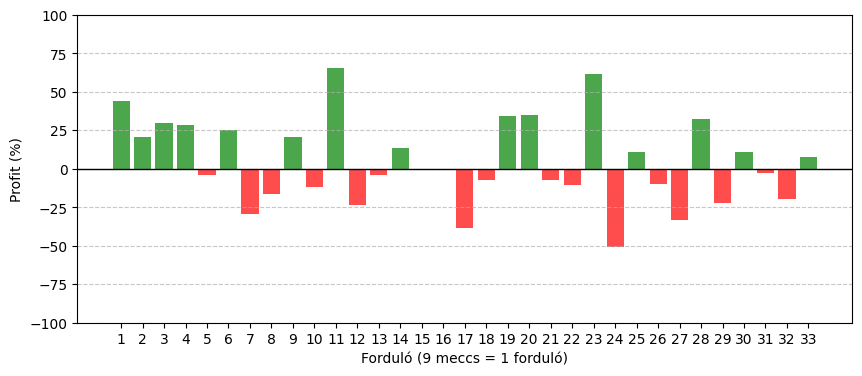

In [476]:
ROI_sim_UO(bundesliga_tuned_UO, round_size=9)

## Serie A

In [ ]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


serie_a_tuned_UO, it_lr_uo, serie_a_features_UO, serie_a_scaler_UO= logistic_regression_tuning_underover(
    serie_a,  
    target_col,
    drop,
    odds
)

In [479]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(serie_a_tuned_UO, stake=1)

ROI: -1.41%


## La Liga

In [ ]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


la_liga_tuned_UO, sp_lr_uo, la_liga_features_UO, laliga_scaler_UO= logistic_regression_tuning_underover(
    la_liga, 
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 3327)
teszt halmaz:  (i: 3328 -> 3697)

Best threshold: 0.47, Best F1: 0.6431


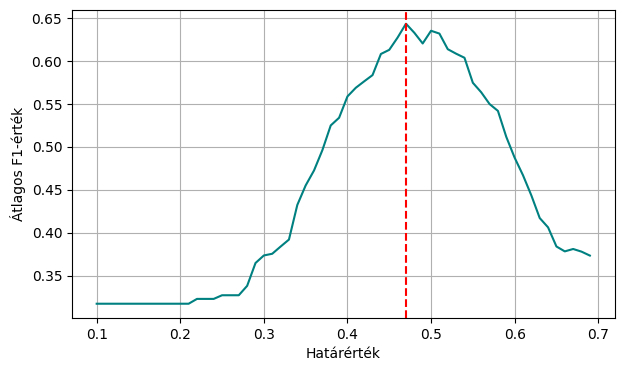

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       198
           1       0.61      0.67      0.64       172

    accuracy                           0.64       370
   macro avg       0.64      0.64      0.64       370
weighted avg       0.65      0.64      0.64       370



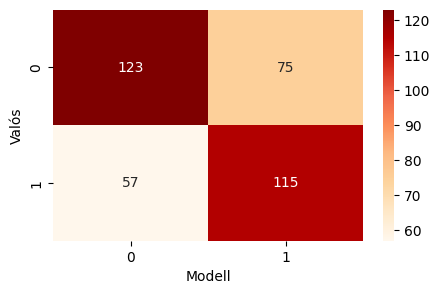

In [222]:
# target_col = 'target_o2.5'
# drop = ['target_home_win', 'target_away_win', 'target_draw',
#        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

# la_liga_test_UO = logistic_regression_test_underover(
#     la_liga,
#     target_col,
#     drop,
#     odds,
#     la_liga_params_UO
# )

In [481]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(la_liga_tuned_UO, stake=1)

ROI: 6.95%


>0% profit 25 fordulóban


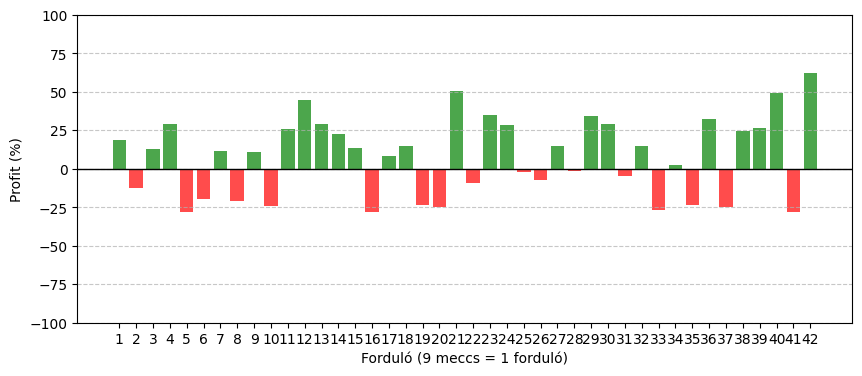

In [482]:
ROI_sim_UO(la_liga_tuned_UO, round_size=9)

## Ligue 1


Tanító halmaz indexek: (i: 1 -> 2816)
Validációs halmaz:  (i: 2817 -> 3168)
Teszt halmaz:  (i: 3169 -> 3521)

Legjobb hiperparaméterek:
C: 429.8855215124967
class_weight: balanced
max_iter: 500
penalty: l1
solver: liblinear

Legjobb threshold: 0.57, Legjobb F1: 0.5479


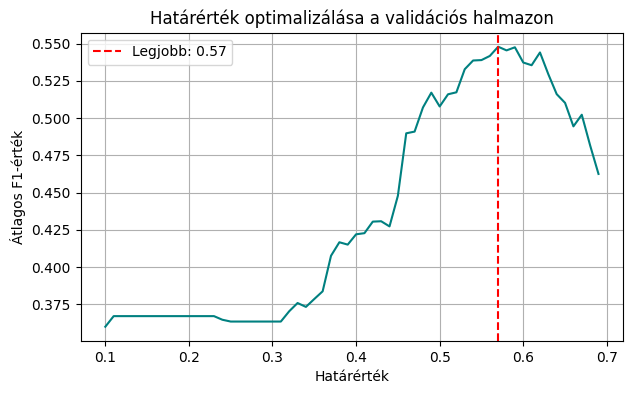


Validációs halmaz eredményei:
              precision    recall  f1-score   support

           0       0.49      0.59      0.53       154
           1       0.62      0.52      0.56       198

    accuracy                           0.55       352
   macro avg       0.55      0.55      0.55       352
weighted avg       0.56      0.55      0.55       352



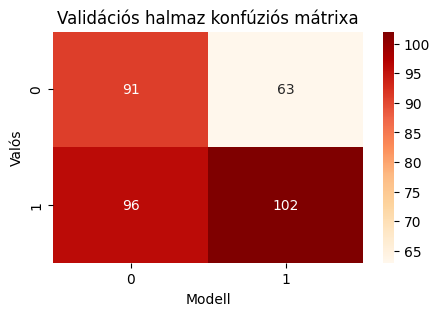

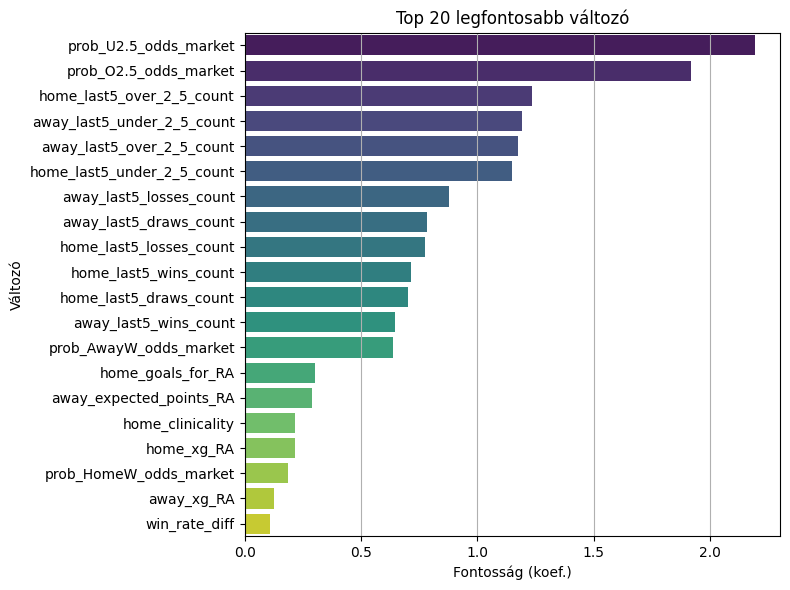


Teszt halmaz eredményei:
              precision    recall  f1-score   support

           0       0.50      0.58      0.54       163
           1       0.58      0.50      0.54       190

    accuracy                           0.54       353
   macro avg       0.54      0.54      0.54       353
weighted avg       0.54      0.54      0.54       353



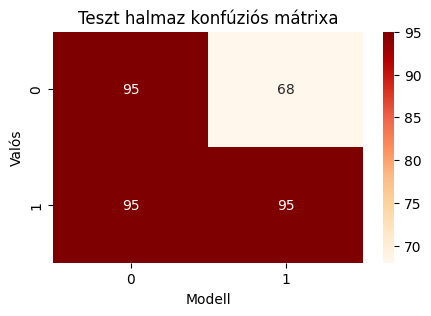

In [8]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


ligue_1_tuned_UO, fr_lr_uo, ligue_1_features_UO, ligue1_scaler_UO= logistic_regression_tuning_underover(
    ligue_1,  
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 3169)
teszt halmaz:  (i: 3170 -> 3521)

Best threshold: 0.53, Best F1: 0.5484


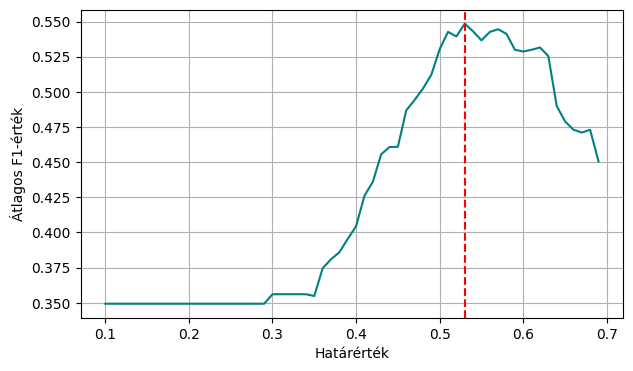

              precision    recall  f1-score   support

           0       0.52      0.48      0.50       163
           1       0.58      0.62      0.60       189

    accuracy                           0.55       352
   macro avg       0.55      0.55      0.55       352
weighted avg       0.55      0.55      0.55       352



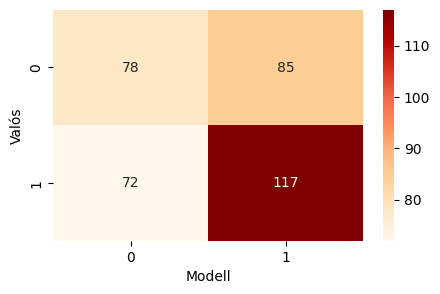

In [226]:
# target_col = 'target_o2.5'
# drop = ['target_home_win', 'target_away_win', 'target_draw',
#        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

# ligue_1_test_UO = logistic_regression_test_underover(
#     ligue_1,
#     target_col,
#     drop,
#     odds,
#     ligue_1_params_UO
# )

In [484]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(ligue_1_tuned_UO, stake=1)

ROI: -6.65%


>0% profit 15 fordulóban


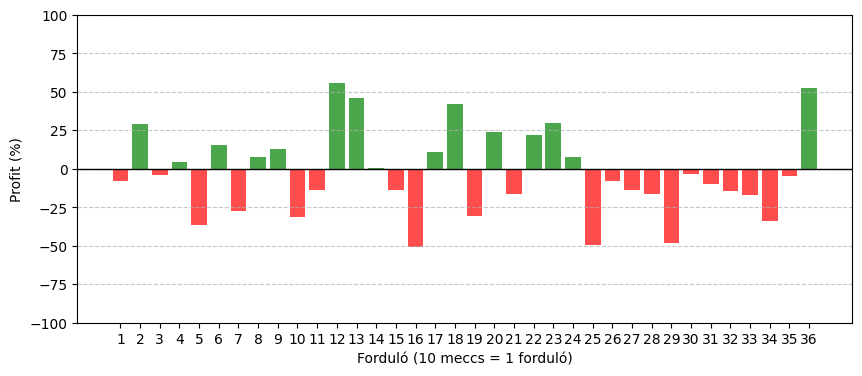

In [228]:
ROI_sim_UO(ligue_1_test_UO, round_size=10)

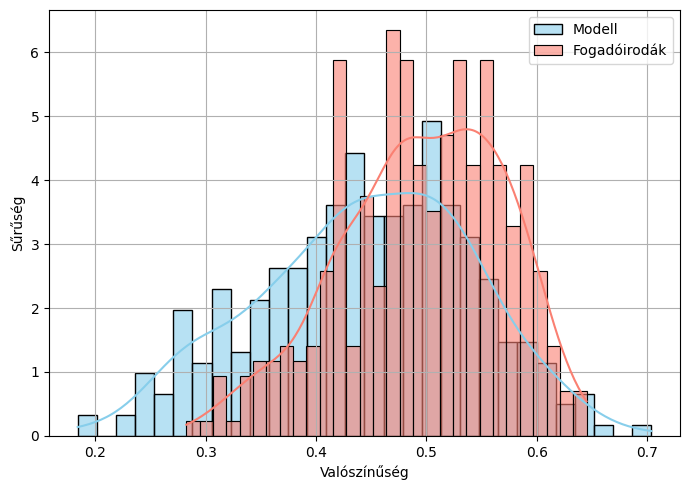

In [303]:
prob_dist_uo(ligue_1_test_UO)

## Kombinált


tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)
teszt halmaz:  (i: 15718 -> 17464)

Legjobb threshold: 0.53, Legjobb F1: 0.5785


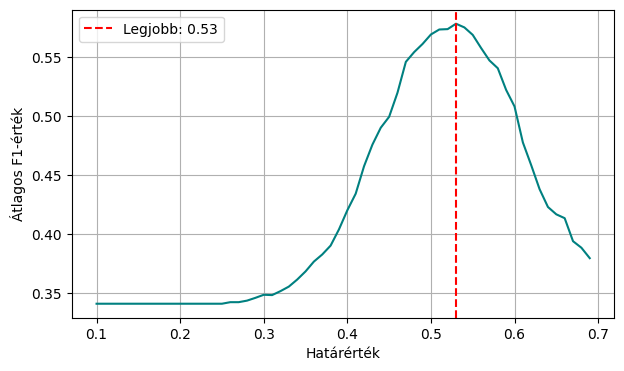

              precision    recall  f1-score   support

           0       0.56      0.60      0.58       843
           1       0.60      0.55      0.58       903

    accuracy                           0.58      1746
   macro avg       0.58      0.58      0.58      1746
weighted avg       0.58      0.58      0.58      1746



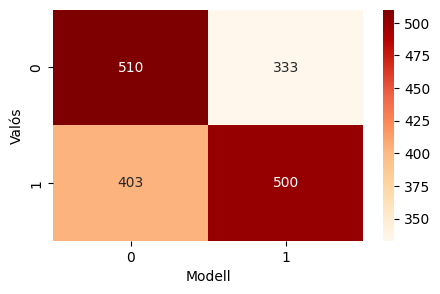

['prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'home_goals_for_RA', 'away_np_xg_RA', 'away_expected_points_RA', 'away_xg_RA', 'home_clinicality', 'home_np_xg_difference_RA', 'home_goals_against_RA', 'away_shots_RA', 'away_goals_against_RA', 'away_cumulative_goals_diff', 'cumulative_points_diff', 'home_deep_completions_RA', 'prob_AwayW_odds_market', 'away_ppda_RA', 'away_deep_completions_RA', 'home_xg_RA', 'home_points_RA', 'away_last5_over_2_5_count']


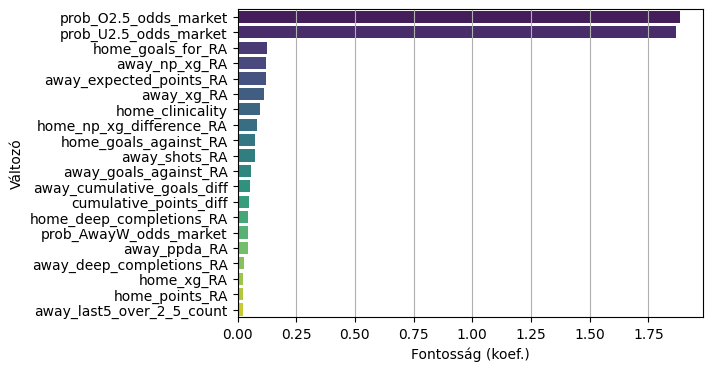

In [229]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


big5_tuned_UO, big5_params_UO, big5_features_UO = logistic_regression_tuning_underover(
    big5,  
    target_col,
    drop,
    odds
)

In [231]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(big5_test_UO, stake=1)

ROI: -0.27%


>0% profit 18 fordulóban


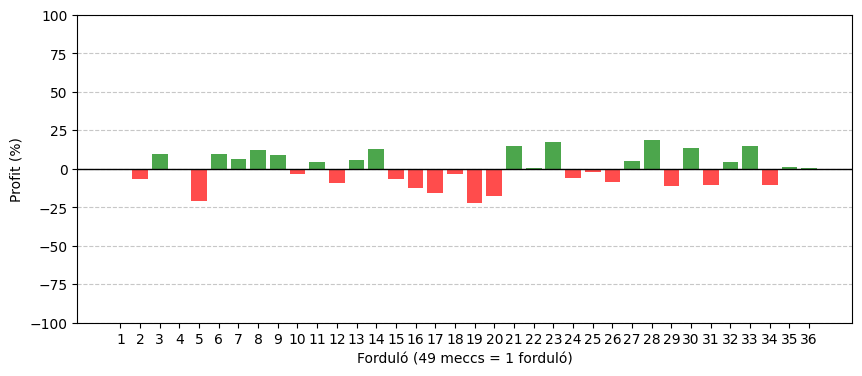

In [236]:
ROI_sim_UO(big5_test_UO, round_size=49)

# összehasonlitas

## UO

### Fgv-k definiálása

In [10]:
def logreg_dict_underover(model, input_df, df_dict, target_col, drop_cols=[], odds=[], stake=1):
    results = {}
    scaler_fit_idx = int(len(input_df) * 0.8)
    scaler_fit_data = input_df.iloc[:scaler_fit_idx].drop(columns=[target_col] + drop_cols + odds)

    scaler = StandardScaler()
    scaler.fit(scaler_fit_data)

    for league_name, df in df_dict.items():
        print(f"\n=== {league_name} ===")
        
        df_cleaned = df.dropna().reset_index(drop=True)

        X_base = df_cleaned.drop(columns=[target_col] + drop_cols)
        y_base = df_cleaned[target_col]

        chunk_size = len(df_cleaned) // 10
        test_results = []

        for i in range(10):
            start_idx = i * chunk_size
            end_idx = len(df_cleaned) if i == 9 else (i + 1) * chunk_size

            X_chunk = X_base.iloc[start_idx:end_idx].reset_index(drop=True)
            y_chunk = y_base.iloc[start_idx:end_idx].reset_index(drop=True)
            df_chunk = df_cleaned.iloc[start_idx:end_idx].copy()

            X_chunk_scaled = scaler.transform(X_chunk.drop(columns=odds))
            X_chunk_scaled = pd.DataFrame(X_chunk_scaled, columns=X_chunk.drop(columns=odds).columns)
            X_chunk = pd.concat([X_chunk_scaled, X_chunk[odds].reset_index(drop=True)], axis=1)

            probs_chunk = model.predict_proba(X_chunk)
            preds_chunk = (probs_chunk[:, 1] >= 0.5).astype(int)

            acc = accuracy_score(y_chunk, preds_chunk)
            f1 = f1_score(y_chunk, preds_chunk, average='macro')

            df_chunk['Predicted'] = preds_chunk
            df_chunk['Profit'] = df_chunk.apply(
                lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row[target_col] == 1 else
                            (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row[target_col] == 0 else
                            -stake, axis=1
            )
            total_profit = df_chunk['Profit'].sum()
            roi = (total_profit / (len(df_chunk) * stake)) * 100

            print(f"{i+1}. szezon: Pontosság = {acc:.4f}, F1-macro = {f1:.4f}, ROI = {roi:.2f}%")
            print(f"Indexek: {start_idx} - {end_idx - 1}")

            test_results.append({
                'season': i + 1,
                'start_idx': start_idx,
                'end_idx': end_idx - 1,
                'accuracy': acc,
                'f1_macro': f1,
                'roi': roi
            })

        X_scaled = scaler.transform(X_base.drop(columns=odds))
        X_scaled = pd.DataFrame(X_scaled, columns=X_base.drop(columns=odds).columns)
        X_final = pd.concat([X_scaled, X_base[odds].reset_index(drop=True)], axis=1)

        probs_all = model.predict_proba(X_final)
        preds_all = (probs_all[:, 1] >= 0.5).astype(int)

        acc_all = accuracy_score(y_base, preds_all)
        f1_all = f1_score(y_base, preds_all, average='macro')

        df_result = df_cleaned.copy()
        df_result['P_0'] = probs_all[:, 0]
        df_result['P_1'] = probs_all[:, 1]
        df_result['Predicted'] = preds_all

        df_result['Profit'] = df_result.apply(
            lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row[target_col] == 1 else
                        (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row[target_col] == 0 else
                        -stake, axis=1
        )
        total_profit = df_result['Profit'].sum()
        roi_all = (total_profit / (len(df_result) * stake)) * 100

        print(f"\nTeljes adathalmaz: Pontosság = {acc_all:.4f}, F1-macro = {f1_all:.4f}, ROI = {roi_all:.2f}%")

        results[league_name] = {
            'predictions': df_result,
            'partial_scores': test_results,
            'full_scores': {
                'accuracy': acc_all,
                'f1_macro': f1_all,
                'roi': roi_all
            }
        }

    return results

### PL

In [800]:
pl_dict = {
    'La Liga': la_liga,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'Bundesliga': bundesliga
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_pl = logreg_dict_underover(
    model=pl_lr_uo, 
    input_df=premier_league,
    df_dict=pl_dict,
    target_col='target_o2.5',  
    drop_cols=drop,  
    odds=odds 
)


=== La Liga ===
1. szezon: Pontosság = 0.5528, F1-macro = 0.5458, ROI = -10.72%
Indexek: 0 - 368
2. szezon: Pontosság = 0.5854, F1-macro = 0.5846, ROI = -3.45%
Indexek: 369 - 737
3. szezon: Pontosság = 0.6152, F1-macro = 0.6151, ROI = 1.27%
Indexek: 738 - 1106
4. szezon: Pontosság = 0.5637, F1-macro = 0.5636, ROI = -6.89%
Indexek: 1107 - 1475
5. szezon: Pontosság = 0.5827, F1-macro = 0.5823, ROI = -2.71%
Indexek: 1476 - 1844
6. szezon: Pontosság = 0.5962, F1-macro = 0.5845, ROI = -2.08%
Indexek: 1845 - 2213
7. szezon: Pontosság = 0.5962, F1-macro = 0.5614, ROI = -0.33%
Indexek: 2214 - 2582
8. szezon: Pontosság = 0.5664, F1-macro = 0.5383, ROI = -2.60%
Indexek: 2583 - 2951
9. szezon: Pontosság = 0.5745, F1-macro = 0.5622, ROI = -2.04%
Indexek: 2952 - 3320
10. szezon: Pontosság = 0.6383, F1-macro = 0.6307, ROI = 7.87%
Indexek: 3321 - 3696

Teljes adathalmaz: Pontosság = 0.5872, F1-macro = 0.5811, ROI = -2.15%

=== Ligue 1 ===
1. szezon: Pontosság = 0.5938, F1-macro = 0.5161, ROI = -0.79

### bundesliga

In [739]:
bundesliga_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Serie A':serie_a,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_bundeslgia = logreg_dict_underover(
    model=gm_lr_uo,
    input_df=bundesliga,
    df_dict=bundesliga_dict,
    target_col='target_o2.5',
    drop_cols=drop
)


=== La Liga ===
1. szezon: Pontosság = 0.5908, F1-macro = 0.5649, ROI = -3.85%
Indexek: 0 - 368
2. szezon: Pontosság = 0.5637, F1-macro = 0.5464, ROI = -7.87%
Indexek: 369 - 737
3. szezon: Pontosság = 0.5881, F1-macro = 0.5824, ROI = -4.34%
Indexek: 738 - 1106
4. szezon: Pontosság = 0.6043, F1-macro = 0.5966, ROI = -0.42%
Indexek: 1107 - 1475
5. szezon: Pontosság = 0.5556, F1-macro = 0.5364, ROI = -8.34%
Indexek: 1476 - 1844
6. szezon: Pontosság = 0.6179, F1-macro = 0.5760, ROI = 1.88%
Indexek: 1845 - 2213
7. szezon: Pontosság = 0.5799, F1-macro = 0.5069, ROI = -4.09%
Indexek: 2214 - 2582
8. szezon: Pontosság = 0.5745, F1-macro = 0.5006, ROI = -2.62%
Indexek: 2583 - 2951
9. szezon: Pontosság = 0.5583, F1-macro = 0.5060, ROI = -6.81%
Indexek: 2952 - 3320
10. szezon: Pontosság = 0.6011, F1-macro = 0.5694, ROI = 0.42%
Indexek: 3321 - 3696

Teljes adathalmaz: Pontosság = 0.5834, F1-macro = 0.5538, ROI = -3.60%

=== Ligue 1 ===
1. szezon: Pontosság = 0.5739, F1-macro = 0.4361, ROI = -6.45%

### serie a

In [741]:
seriea_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

results_seriea = logreg_dict_underover(
    model=it_lr_uo,
    input_df=serie_a,
    df_dict=seriea_dict,
    target_col='target_o2.5',
    drop_cols=drop
)


=== La Liga ===
1. szezon: Pontosság = 0.5393, F1-macro = 0.5296, ROI = -13.53%
Indexek: 0 - 368
2. szezon: Pontosság = 0.5772, F1-macro = 0.5761, ROI = -5.15%
Indexek: 369 - 737
3. szezon: Pontosság = 0.6233, F1-macro = 0.6228, ROI = 2.87%
Indexek: 738 - 1106
4. szezon: Pontosság = 0.5664, F1-macro = 0.5663, ROI = -6.95%
Indexek: 1107 - 1475
5. szezon: Pontosság = 0.5827, F1-macro = 0.5813, ROI = -3.18%
Indexek: 1476 - 1844
6. szezon: Pontosság = 0.6016, F1-macro = 0.5820, ROI = -1.18%
Indexek: 1845 - 2213
7. szezon: Pontosság = 0.6043, F1-macro = 0.5601, ROI = 0.84%
Indexek: 2214 - 2582
8. szezon: Pontosság = 0.5664, F1-macro = 0.5298, ROI = -3.18%
Indexek: 2583 - 2951
9. szezon: Pontosság = 0.5745, F1-macro = 0.5557, ROI = -2.66%
Indexek: 2952 - 3320
10. szezon: Pontosság = 0.6463, F1-macro = 0.6332, ROI = 9.49%
Indexek: 3321 - 3696

Teljes adathalmaz: Pontosság = 0.5883, F1-macro = 0.5787, ROI = -2.24%

=== Ligue 1 ===
1. szezon: Pontosság = 0.6023, F1-macro = 0.5140, ROI = 0.48%


### laliga 

In [743]:
laliga_dict = {
    'Serie A': serie_a,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

results_laliga = logreg_dict_underover(
    model=sp_lr_uo,
    input_df=la_liga,
    df_dict=laliga_dict,
    target_col='target_o2.5',
    drop_cols=drop
)


=== Serie A ===
1. szezon: Pontosság = 0.5070, F1-macro = 0.4975, ROI = -6.86%
Indexek: 0 - 356
2. szezon: Pontosság = 0.4874, F1-macro = 0.4832, ROI = -11.18%
Indexek: 357 - 713
3. szezon: Pontosság = 0.6106, F1-macro = 0.5592, ROI = 6.72%
Indexek: 714 - 1070
4. szezon: Pontosság = 0.5350, F1-macro = 0.4996, ROI = -9.61%
Indexek: 1071 - 1427
5. szezon: Pontosság = 0.5434, F1-macro = 0.5432, ROI = -1.92%
Indexek: 1428 - 1784
6. szezon: Pontosság = 0.5546, F1-macro = 0.5116, ROI = -5.22%
Indexek: 1785 - 2141
7. szezon: Pontosság = 0.5462, F1-macro = 0.5014, ROI = -5.76%
Indexek: 2142 - 2498
8. szezon: Pontosság = 0.5546, F1-macro = 0.4764, ROI = -4.07%
Indexek: 2499 - 2855
9. szezon: Pontosság = 0.5462, F1-macro = 0.5407, ROI = -1.09%
Indexek: 2856 - 3212
10. szezon: Pontosság = 0.5068, F1-macro = 0.5023, ROI = -10.19%
Indexek: 3213 - 3577

Teljes adathalmaz: Pontosság = 0.5391, F1-macro = 0.5200, ROI = -4.93%

=== Ligue 1 ===
1. szezon: Pontosság = 0.5625, F1-macro = 0.5333, ROI = -2.

### ligue 1

In [11]:
ligue1_dict = {
    'Serie A': serie_a,
    'La Liga':la_liga,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

results_laliga = logreg_dict_underover(
    model=fr_lr_uo,
    input_df=ligue_1,
    df_dict=ligue1_dict,
    target_col='target_o2.5',
    drop_cols=drop
)


=== Serie A ===
1. szezon: Pontosság = 0.5462, F1-macro = 0.5462, ROI = -5.22%
Indexek: 0 - 356
2. szezon: Pontosság = 0.5406, F1-macro = 0.5362, ROI = -7.61%
Indexek: 357 - 713
3. szezon: Pontosság = 0.5770, F1-macro = 0.5344, ROI = -3.83%
Indexek: 714 - 1070
4. szezon: Pontosság = 0.5910, F1-macro = 0.5570, ROI = -2.01%
Indexek: 1071 - 1427
5. szezon: Pontosság = 0.5434, F1-macro = 0.5193, ROI = -6.78%
Indexek: 1428 - 1784
6. szezon: Pontosság = 0.6246, F1-macro = 0.4909, ROI = 4.45%
Indexek: 1785 - 2141
7. szezon: Pontosság = 0.5826, F1-macro = 0.4445, ROI = -3.94%
Indexek: 2142 - 2498
8. szezon: Pontosság = 0.5630, F1-macro = 0.4549, ROI = -4.72%
Indexek: 2499 - 2855
9. szezon: Pontosság = 0.5378, F1-macro = 0.5341, ROI = -6.63%
Indexek: 2856 - 3212
10. szezon: Pontosság = 0.6055, F1-macro = 0.6054, ROI = 4.86%
Indexek: 3213 - 3577

Teljes adathalmaz: Pontosság = 0.5713, F1-macro = 0.5482, ROI = -3.12%

=== La Liga ===
1. szezon: Pontosság = 0.5881, F1-macro = 0.5878, ROI = -5.51%

## FTR

### Fgv-k definiálása

In [785]:
def logreg_general(df, df_test, drop_cols_home=[], drop_cols_away=[], odds=[], best_params_home={}, best_params_away={},
                  df_name='', df_test_name=''):
    """
    A logisztikus regresszió összehasonlítását végzi.
    df: A tanító és val halmazt adó bajnokság.
    df_test: A teszthalmazt adó bajnokság
    drop_cols_home, drop_cols_away: Az eldobandó változók
    odds: A vszg.-ek, amelyeket skálázás előtt eltávolítunk, utána visszarakunk.
    best_params_home, best_params_away: A keresztvalidálás során megállapított legjobb hiperparaméterek.
    df_name: A train es val halmazt adó bajnokság neve.
    df_test_name: A teszt halmazt adó bajnokság neve.
    """
    
    df = df.dropna().reset_index(drop=True)
    df_test = df_test.dropna().reset_index(drop=True)
    """
    Szétválasztom a train, val és test seteket.
    A train az első 8 szezon.
    A val a 9.
    A test a 10. A lényeg, hogy a test másik ligából jön.
    Pl. Ha a PL-t hasonlítom össze a többi ligával, akkor
        A train a PL első 8 szezonja,  ezen történik a CV, hiperpm-hangolás
        A val a 9. szezonja, ezen történik a határérték kiválasztása - előrejelzek ezen is, majd azt
        a határértéket választom, amely maximalizálja a val halmazon az F1 macrot.
        A test pedig minden más liga 10. szezonja. Ezen csak előrejelzek, és a szavazókkal osztályzok - azt a határértéket használom, 
        amit a valon maximalizáltam. 
    """
    
    train_n = int(round(len(df) * 0.8, 0)) 
    train_set = df.iloc[:train_n].copy()
    
    val_set = df.iloc[train_n:].copy()
    
    # A teszthalmazt 10%-os szekciókra bontjuk
    test_segment_size = int(round(len(df_test) * 0.1, 0))
    test_segments = []
    for i in range(10):
        start_idx = i * test_segment_size
        end_idx = start_idx + test_segment_size if i < 9 else len(df_test)
        test_segments.append(df_test.iloc[start_idx:end_idx].copy())
    
    print(f"train_set indexek: {train_set.index[0]}–{train_set.index[-1]} | forrás: {df_name}")
    print(f"val_set indexek: {val_set.index[0]}–{val_set.index[-1]} | forrás: {df_name}")
    for i, segment in enumerate(test_segments):
        if not segment.empty:
            print(f"test_segment_{i+1} indexek: {segment.index[0]}–{segment.index[-1]} | forrás: {df_test_name}")
    """
    Tanítás a train adatokon, a CV során lementett legjobb hiperparaméterekkel.
    Külön a home és away - nincs okom feltételezni, hogy ugyanazok lennének a hiperparaméterek.
    """
    
    lr_home, scaler_home = logreg_validation(
        train_set, "target_home_win", drop_cols_home, odds, best_params_home
    )
    lr_away, scaler_away = logreg_validation(
        train_set, "target_away_win", drop_cols_away, odds, best_params_away
    )
    """
    Normalizálom a validációs halmazt, a vszg-k nélkül, ezek a normalizálás után visszakerülnek.
    """
    
    X_val_home = val_set.drop(columns=drop_cols_home + ["target_home_win"])
    X_val_away = val_set.drop(columns=drop_cols_away + ["target_away_win"])
    X_val_home_odds = X_val_home[odds].copy()
    X_val_away_odds = X_val_away[odds].copy()
    X_val_home_no_odds = X_val_home.drop(columns=odds)
    X_val_away_no_odds = X_val_away.drop(columns=odds)
    X_val_home_scaled = scaler_home.transform(X_val_home_no_odds)
    X_val_away_scaled = scaler_away.transform(X_val_away_no_odds)
    X_val_home_scaled = pd.DataFrame(X_val_home_scaled, columns=X_val_home_no_odds.columns)
    X_val_away_scaled = pd.DataFrame(X_val_away_scaled, columns=X_val_away_no_odds.columns)
    X_val_home_scaled = pd.concat([X_val_home_scaled.reset_index(drop=True), 
                                   X_val_home_odds.reset_index(drop=True)], axis=1)
    X_val_away_scaled = pd.concat([X_val_away_scaled.reset_index(drop=True), 
                                   X_val_away_odds.reset_index(drop=True)], axis=1)
    """
    Előrejelzek a val halmazon, definiálom a vszgket, 0-1 között fixálom őket.
    """
    
    prob_home_win_val = lr_home.predict_proba(X_val_home_scaled)[:, 1]
    prob_away_win_val = lr_away.predict_proba(X_val_away_scaled)[:, 1]
    prob_home_win_val = np.maximum(prob_home_win_val, 0)
    prob_away_win_val = np.maximum(prob_away_win_val, 0)
    prob_draw_val = np.maximum(1 - (prob_home_win_val + prob_away_win_val), 0)
    total_prob_val = prob_home_win_val + prob_away_win_val + prob_draw_val
    prob_home_win_val /= total_prob_val
    prob_away_win_val /= total_prob_val
    prob_draw_val /= total_prob_val
    """
    Küszöb/határérték megállapítása.
    Tárolom a macrot és az F1-t, végigiterálok a thresholds halmazán, frissítem az értéket, 
    ha magasabb, mint az aktuálisan maximum.
    Ez csak a validációs előrejelzésen történik.
    """
    
    best_f1_macro = 0
    best_threshold = 0.15
    thresholds = np.arange(0.01, 0.30, 0.01)
    true_outcomes_val = []
    for i in range(len(val_set)):
        if val_set.iloc[i]["target_home_win"] == 1:
            true_outcomes_val.append("Home Win")
        elif val_set.iloc[i]["target_away_win"] == 1:
            true_outcomes_val.append("Away Win")
        else:
            true_outcomes_val.append("Draw")
    for threshold in thresholds:
        predictions = []
        for i in range(len(val_set)):
            home_prob = prob_home_win_val[i]
            away_prob = prob_away_win_val[i]
            if abs(home_prob - away_prob) < threshold:
                predictions.append("Draw")
            elif home_prob > away_prob:
                predictions.append("Home Win")
            else:
                predictions.append("Away Win")
        f1_macro = f1_score(true_outcomes_val, predictions, average='macro')
        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_threshold = threshold
    
    # Minden szegmens feldolgozása
    results_df = pd.DataFrame()
    
    for segment_idx, test_segment in enumerate(test_segments):
        if test_segment.empty:
            continue
            
        """
        Normalizálom a teszt szegmenst, ugyanúgy, mint a valt.
        """
        
        X_test_home = test_segment.drop(columns=["target_home_win"] + drop_cols_home)
        X_test_away = test_segment.drop(columns=["target_away_win"] + drop_cols_away)
        X_test_home_odds = X_test_home[odds].copy()
        X_test_away_odds = X_test_away[odds].copy()
        X_test_home_no_odds = X_test_home.drop(columns=odds)
        X_test_away_no_odds = X_test_away.drop(columns=odds)
        X_test_home_scaled = scaler_home.transform(X_test_home_no_odds)
        X_test_away_scaled = scaler_away.transform(X_test_away_no_odds)
        X_test_home_scaled = pd.DataFrame(X_test_home_scaled, columns=X_test_home_no_odds.columns)
        X_test_away_scaled = pd.DataFrame(X_test_away_scaled, columns=X_test_away_no_odds.columns)
        X_test_home_scaled = pd.concat([X_test_home_scaled.reset_index(drop=True), X_test_home_odds.reset_index(drop=True)], axis=1)
        X_test_away_scaled = pd.concat([X_test_away_scaled.reset_index(drop=True), X_test_away_odds.reset_index(drop=True)], axis=1)
        """
        Előrejelzés a külső ligák teszthalmazán.
        Ugyanúgy járok el a vszg-kel, mint a val halmazon
        """
        
        model_home_preds = lr_home.predict(X_test_home_scaled)
        model_away_preds = lr_away.predict(X_test_away_scaled)
        prob_home_win_test = lr_home.predict_proba(X_test_home_scaled)[:, 1]
        prob_away_win_test = lr_away.predict_proba(X_test_away_scaled)[:, 1]
        prob_home_win_test = np.maximum(prob_home_win_test, 0)
        prob_away_win_test = np.maximum(prob_away_win_test, 0)
        prob_draw_test = np.maximum(1 - (prob_home_win_test + prob_away_win_test), 0)
        total_prob_test = prob_home_win_test + prob_away_win_test + prob_draw_test
        prob_home_win_test /= total_prob_test
        prob_away_win_test /= total_prob_test
        prob_draw_test /= total_prob_test
        test_indices = test_segment.index
        test_segment.loc[test_indices, "model_home"] = model_home_preds
        test_segment.loc[test_indices, "model_away"] = model_away_preds
        test_segment.loc[test_indices, "prob_home_win"] = prob_home_win_test
        test_segment.loc[test_indices, "prob_away_win"] = prob_away_win_test
        test_segment.loc[test_indices, "prob_draw"] = prob_draw_test
        test_segment["segment"] = segment_idx + 1
        """
        Szavazó algoritmusok.
        Softnál döntetlen, ha a két kimenetel abszolút különbsége kisebb, mint a 
        validációs halmazon F1-et maximalizáló határérték.
        """
        
        def voting_hard(row):
            if row["model_home"] == 1 and row["model_away"] == 0:
                return "Home Win"
            elif row["model_away"] == 1 and row["model_home"] == 0:
                return "Away Win"
            elif row["model_home"] == 0 and row["model_away"] == 0:
                return "Draw"
            elif row["model_home"] == 1 and row["model_away"] == 1:
                return "Home Win"
            else:
                return "-"
        def voting_soft(row):
            prob_home_win = row['prob_home_win']
            prob_away_win = row['prob_away_win']
            if abs(prob_home_win - prob_away_win) < best_threshold:
                return "Draw"
            elif prob_home_win > prob_away_win:
                return "Home Win"
            elif prob_home_win < prob_away_win:
                return "Away Win"
            else:
                return "-"
        test_segment["test_pred_hard"] = test_segment.apply(voting_hard, axis=1)
        test_segment["test_pred_soft"] = test_segment.apply(voting_soft, axis=1)
        
        # Az eredményeket hozzáfűzzük a végső dataframe-hez
        results_df = pd.concat([results_df, test_segment])
    
    
    """
    Az a küszöbérték, amellyel a val halmazon max. lett az F1 csoportátlag - ugye ez kerül
    használatra a teszt halmazon.
    """
    
    print(f"Legjobb küszöbérték a validációs halmazon: {best_threshold:.2f}")
    return results_df, lr_home, lr_away

In [786]:
def evaluation_general(pred_odds):

    accuracy_hard = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    f1_macro_hard = f1_score(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"], average='macro')

    accuracy_soft = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    f1_macro_soft = f1_score(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"], average='macro')

    return (f1_macro_hard, accuracy_hard, f1_macro_soft, accuracy_soft)

In [793]:
def logreg_dictionary_ftr(df, test_df_dict, drop_cols_home, drop_cols_away, odds,
                           best_params_home, best_params_away, train_name):
    
    """
    Ez a fgv. behívja a logreg_general()-t, és végigterál egy olyan
    dictionary-n, amelyben minden bajnokság benne van, kivéve az éppen tanulót,
    és a kombináltat.
    
    df: A tanító és val halmazt adó bajnokság.
    test_df_dict: A teszthalmazt adó bajnokságok df-jeit tartalmazó dictionary.
    drop_cols_home, drop_cols_away: Az eldobandó változók
    odds: A vszg.-ek, amelyeket skálázás előtt eltávolítunk, utána visszarakunk.
    best_params_home, best_params_away: A keresztvalidálás során megállapított legjobb hiperparaméterek.
    df_name: A train es val halmazt adó bajnokság neve.
    df_test_name: A teszt halmazt adó bajnokság neve.

    Például:
    Ha a PL-n tanult modellt hasonlítom össze, akkor az input dictionaryben
    a Serie A, a Ligue 1, a Bundesliga és a La Liga lesznek. 

    Az előrejelzés ezeknek a 10. szezonján történik.
    """
    
    results = {}

    for league_name, test_df in test_df_dict.items():
        print(f"\n{'='*50}\nFuttatás {train_name} → {league_name}\n{'='*50}")
        
        test_predictions, lr_home, lr_away = logreg_general(
            df,
            test_df,
            drop_cols_home,
            drop_cols_away,
            odds,
            best_params_home,
            best_params_away,
            df_name=train_name,
            df_test_name=league_name
        )

        pred_odds = process_predictions(test_predictions)
        
        evaluation_general(pred_odds)

        roi_hard, roi_soft, df_profit_hard, df_loss_hard, df_profit_soft, df_loss_soft, pred_odds_soft = betting_logreg(
            pred_odds,
            stake=1
        )

        results[league_name] = {
            "test_predictions": test_predictions,
            "logreg_home": lr_home,
            "logreg_away": lr_away,
            "pred_odds": pred_odds,
            "roi_hard": roi_hard,
            "roi_soft": roi_soft,
            "df_profit_hard": df_profit_hard,
            "df_loss_hard": df_loss_hard,
            "df_profit_soft": df_profit_soft,
            "df_loss_soft": df_loss_soft,
            "pred_odds_soft": pred_odds_soft
        }

        chunk_size = int(len(test_df) * 0.1)
        segment_results = []
        
        print(f"\n{'='*30}\nSzegmensenkénti (10%-os) értékelés\n{'='*30}")
        
        f1_macro_hard_list = []
        accuracy_hard_list = []
        f1_macro_soft_list = []
        accuracy_soft_list = []
        roi_hard_list = []
        roi_soft_list = []

        for i in range(10):
            start_idx = i * chunk_size
            end_idx = start_idx + chunk_size
            
            if i == 9:
                end_idx = len(test_predictions)
            
            segment_predictions = test_predictions.iloc[start_idx:end_idx].copy() if start_idx < len(test_predictions) else None
            
            if segment_predictions is None or len(segment_predictions) == 0:
                print(f"\nSzegmens {i + 1}: Nincs elég adat")
                continue
            
            print(f"\n--- Szegmens {i + 1} (index: {start_idx}-{end_idx - 1}) ---")
            
            segment_pred_odds = process_predictions(segment_predictions)
            
            f1_macro_hard, accuracy_hard, f1_macro_soft, accuracy_soft = evaluation_general(segment_pred_odds)            
            segment_roi_hard, segment_roi_soft, _, _, _, _, _ = betting_logreg(
                segment_pred_odds,
                stake=1,
            )

            print(f"F1 macro (Hard): {f1_macro_hard:.4f}, Pontosság (Hard): {accuracy_hard:.4f}")
            print(f"F1 macro (Soft): {f1_macro_soft:.4f}, Pontosság (Soft): {accuracy_soft:.4f}")
            print(f"ROI Hard: {segment_roi_hard:.2f}%, ROI Soft: {segment_roi_soft:.2f}%")
            
            f1_macro_hard_list.append(f1_macro_hard)
            accuracy_hard_list.append(accuracy_hard)
            f1_macro_soft_list.append(f1_macro_soft)
            accuracy_soft_list.append(accuracy_soft)
            roi_hard_list.append(segment_roi_hard)
            roi_soft_list.append(segment_roi_soft)

            # F1 macro értékek mentése a df-hez
            # f1_macro_records.append({
            #     "league_name": league_name,
            #     "segment": i + 1,
            #     "f1_macro_hard": f1_macro_hard,
            #     "f1_macro_soft": f1_macro_soft
            # })
        
        avg_f1_macro_hard = np.mean(f1_macro_hard_list)
        std_f1_macro_hard = np.std(f1_macro_hard_list)

        avg_accuracy_hard = np.mean(accuracy_hard_list)
        std_accuracy_hard = np.std(accuracy_hard_list)

        avg_f1_macro_soft = np.mean(f1_macro_soft_list)
        std_f1_macro_soft = np.std(f1_macro_soft_list)

        avg_accuracy_soft = np.mean(accuracy_soft_list)
        std_accuracy_soft = np.std(accuracy_soft_list)

        avg_roi_hard = np.mean(roi_hard_list)
        avg_roi_soft = np.mean(roi_soft_list)

        print(f"\n{'='*30}\nÁtlagos értékek a {league_name} bajnokságban\n{'='*30}")
        print(f"Átlagos F1 macro (Hard Voting): {avg_f1_macro_hard:.4f} ± {std_f1_macro_hard:.4f}")
        print(f"Átlagos pontosság (Hard Voting): {avg_accuracy_hard:.4f} ± {std_accuracy_hard:.4f}")
        print(f"Átlagos ROI hard: {avg_roi_hard:.2f}%")
        print(f"Átlagos F1 macro (Soft Voting): {avg_f1_macro_soft:.4f} ± {std_f1_macro_soft:.4f}")
        print(f"Átlagos pontosság (Soft Voting): {avg_accuracy_soft:.4f} ± {std_accuracy_soft:.4f}")
        print(f"Átlagos ROI soft: {avg_roi_soft:.2f}%")
        
        results[league_name]["segment_results"] = segment_results

    return results


### PL

In [794]:
pl_dict = {
    'La Liga': la_liga,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'Bundesliga': bundesliga
}

odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_pl = logreg_dictionary_ftr(
    premier_league,
    pl_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    premier_league_params_home,
    premier_league_params_away,
    train_name='Premier League'
)


Futtatás Premier League → La Liga
train_set indexek: 0–2957 | forrás: Premier League
val_set indexek: 2958–3697 | forrás: Premier League
test_segment_1 indexek: 0–369 | forrás: La Liga
test_segment_2 indexek: 370–739 | forrás: La Liga
test_segment_3 indexek: 740–1109 | forrás: La Liga
test_segment_4 indexek: 1110–1479 | forrás: La Liga
test_segment_5 indexek: 1480–1849 | forrás: La Liga
test_segment_6 indexek: 1850–2219 | forrás: La Liga
test_segment_7 indexek: 2220–2589 | forrás: La Liga
test_segment_8 indexek: 2590–2959 | forrás: La Liga
test_segment_9 indexek: 2960–3329 | forrás: La Liga
test_segment_10 indexek: 3330–3696 | forrás: La Liga
Legjobb küszöbérték a validációs halmazon: 0.20
ROI hard : -1.97%
ROI soft : -1.11%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-368) ---
ROI hard : -4.92%
ROI soft : 0.02%
F1 macro (Hard): 0.4779, Pontosság (Hard): 0.5393
F1 macro (Soft): 0.5195, Pontosság (Soft): 0.5447
ROI Hard: -4.92%, ROI Soft: 0.02%

--- Szegmens 2 (index: 

### LaLiga

In [795]:
laliga_dict = {
    'PL': premier_league,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'Bundesliga': bundesliga
}

results_laliga = logreg_dictionary_ftr(
    la_liga,
    laliga_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    la_liga_params_home,
    la_liga_params_away,
    train_name='LaLiga'
)



Futtatás LaLiga → PL
train_set indexek: 0–2957 | forrás: LaLiga
val_set indexek: 2958–3696 | forrás: LaLiga
test_segment_1 indexek: 0–369 | forrás: PL
test_segment_2 indexek: 370–739 | forrás: PL
test_segment_3 indexek: 740–1109 | forrás: PL
test_segment_4 indexek: 1110–1479 | forrás: PL
test_segment_5 indexek: 1480–1849 | forrás: PL
test_segment_6 indexek: 1850–2219 | forrás: PL
test_segment_7 indexek: 2220–2589 | forrás: PL
test_segment_8 indexek: 2590–2959 | forrás: PL
test_segment_9 indexek: 2960–3329 | forrás: PL
test_segment_10 indexek: 3330–3697 | forrás: PL
Legjobb küszöbérték a validációs halmazon: 0.16
ROI hard : -3.45%
ROI soft : -2.28%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-368) ---
ROI hard : -9.09%
ROI soft : -2.88%
F1 macro (Hard): 0.4279, Pontosság (Hard): 0.4878
F1 macro (Soft): 0.4766, Pontosság (Soft): 0.4905
ROI Hard: -9.09%, ROI Soft: -2.88%

--- Szegmens 2 (index: 369-737) ---
ROI hard : -7.90%
ROI soft : -5.07%
F1 macro (Hard): 0.4076, Pon

### Budnesliga

In [796]:
bundesliga_dict = {
    'PL': premier_league,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'La Liga': la_liga,
}

results_bundesliga = logreg_dictionary_ftr(
    bundesliga,
    bundesliga_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    bundesliga_params_home,
    bundesliga_params_away,
    train_name='Bundesliga'
)



Futtatás Bundesliga → PL
train_set indexek: 0–2375 | forrás: Bundesliga
val_set indexek: 2376–2969 | forrás: Bundesliga
test_segment_1 indexek: 0–369 | forrás: PL
test_segment_2 indexek: 370–739 | forrás: PL
test_segment_3 indexek: 740–1109 | forrás: PL
test_segment_4 indexek: 1110–1479 | forrás: PL
test_segment_5 indexek: 1480–1849 | forrás: PL
test_segment_6 indexek: 1850–2219 | forrás: PL
test_segment_7 indexek: 2220–2589 | forrás: PL
test_segment_8 indexek: 2590–2959 | forrás: PL
test_segment_9 indexek: 2960–3329 | forrás: PL
test_segment_10 indexek: 3330–3697 | forrás: PL
Legjobb küszöbérték a validációs halmazon: 0.18
ROI hard : -1.79%
ROI soft : -4.12%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-368) ---
ROI hard : -7.45%
ROI soft : 2.39%
F1 macro (Hard): 0.4207, Pontosság (Hard): 0.4986
F1 macro (Soft): 0.4797, Pontosság (Soft): 0.4824
ROI Hard: -7.45%, ROI Soft: 2.39%

--- Szegmens 2 (index: 369-737) ---
ROI hard : -4.32%
ROI soft : -3.94%
F1 macro (Hard): 0

### Serie A

In [797]:
serie_a_dict = {
    'PL': premier_league,
    'Ligue 1': ligue_1,
    'Bundesliga': bundesliga,
    'La Liga': la_liga
}

results_seriea = logreg_dictionary_ftr(
    serie_a,
    serie_a_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    serie_a_params_home,
    serie_a_params_away,
    train_name='Serie A'
)



Futtatás Serie A → PL
train_set indexek: 0–2861 | forrás: Serie A
val_set indexek: 2862–3577 | forrás: Serie A
test_segment_1 indexek: 0–369 | forrás: PL
test_segment_2 indexek: 370–739 | forrás: PL
test_segment_3 indexek: 740–1109 | forrás: PL
test_segment_4 indexek: 1110–1479 | forrás: PL
test_segment_5 indexek: 1480–1849 | forrás: PL
test_segment_6 indexek: 1850–2219 | forrás: PL
test_segment_7 indexek: 2220–2589 | forrás: PL
test_segment_8 indexek: 2590–2959 | forrás: PL
test_segment_9 indexek: 2960–3329 | forrás: PL
test_segment_10 indexek: 3330–3697 | forrás: PL
Legjobb küszöbérték a validációs halmazon: 0.19
ROI hard : -3.20%
ROI soft : -1.75%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-368) ---
ROI hard : -1.86%
ROI soft : 2.54%
F1 macro (Hard): 0.4620, Pontosság (Hard): 0.5203
F1 macro (Soft): 0.4964, Pontosság (Soft): 0.5122
ROI Hard: -1.86%, ROI Soft: 2.54%

--- Szegmens 2 (index: 369-737) ---
ROI hard : -11.09%
ROI soft : -1.95%
F1 macro (Hard): 0.3939, P

### Ligue 1

In [798]:
ligue1_dict = {
    'PL': premier_league,
    'Serie A': serie_a,
    'Bundesliga': bundesliga,
    'La Liga': la_liga
}

results_ligue1 = logreg_dictionary_ftr(
    ligue_1,
    ligue1_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    ligue_1_params_home,
    ligue_1_params_away,
    train_name='Ligue 1'
)



Futtatás Ligue 1 → PL
train_set indexek: 0–2816 | forrás: Ligue 1
val_set indexek: 2817–3520 | forrás: Ligue 1
test_segment_1 indexek: 0–369 | forrás: PL
test_segment_2 indexek: 370–739 | forrás: PL
test_segment_3 indexek: 740–1109 | forrás: PL
test_segment_4 indexek: 1110–1479 | forrás: PL
test_segment_5 indexek: 1480–1849 | forrás: PL
test_segment_6 indexek: 1850–2219 | forrás: PL
test_segment_7 indexek: 2220–2589 | forrás: PL
test_segment_8 indexek: 2590–2959 | forrás: PL
test_segment_9 indexek: 2960–3329 | forrás: PL
test_segment_10 indexek: 3330–3697 | forrás: PL
Legjobb küszöbérték a validációs halmazon: 0.20
ROI hard : -1.75%
ROI soft : -1.14%

Szegmensenkénti (10%-os) értékelés

--- Szegmens 1 (index: 0-368) ---
ROI hard : -2.93%
ROI soft : 4.20%
F1 macro (Hard): 0.4510, Pontosság (Hard): 0.5203
F1 macro (Soft): 0.4989, Pontosság (Soft): 0.5176
ROI Hard: -2.93%, ROI Soft: 4.20%

--- Szegmens 2 (index: 369-737) ---
ROI hard : -1.38%
ROI soft : 2.28%
F1 macro (Hard): 0.4455, Pon